In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

#### Define neural dynamics functions

In [2]:
def act_func(x, n_HPC):
    """
    Nonlinearity applied to the total input each neuron receives.
    Takes the activity of all neurons, x, and applies a non-linear function tanh(x) for HPC neurons and tanh(0.5x) for PFC neurons 
    reflecting differences in responsiveness of neurons in both regions.
    
    Args:
        • x (array): neural activity of all neurons at time t.
        • n_HPC (int): number of hippocampal neurons

    Returns:
        • result (array): 'effective' neural activity of all neurons.
    """
    
    result = np.empty_like(x) 
    result[:n_HPC] = np.tanh(x[:n_HPC])
    result[n_HPC:] = np.tanh(0.5 * x[n_HPC:])  
    return result


def hopfield(x, W, I, n_HPC):
    """
    Neural dynamics
    
    Args:
        • x (array): neural activity of all neurons at time t.
        • W (ndarray): connectivity matrix of the all neurons
        • I (array): input pattern
        • n_HPC (int): number of hippocampal neurons

    Returns:
        • dxdt (array): changes in activity from t to t+dt for each neuron
    """
    
    dxdt = -x + act_func(W @ x + I, n_HPC)
    return dxdt


def hebbian(W, x, learn_rate, decay_rate):
    """
    Learning rule
    
    Args:
        • x (array): neural activity of HPC/PFC neurons at time t.
        • W (ndarray): connectivity matrix of the HPC/PFC neurons
        • learn_rate (int): learning rate of HPC/PFC neurons
        • decay_rate (int): decay rate of HPC/PFC neurons

    Returns:
        • dWdt (array): changes in connectivity from t to t+dt for each neuron pair
    """
    
    firing_rates = np.copy(x)
    
    # Gating of plasticity at 0.4 avoids noise to be encoded.
    # This is important during the sleep phase, when the network loops over many cycles 
    # and where the 'noisy connections' can become amplified with each cycle.
    for j,rate in enumerate(firing_rates): 
        if abs(firing_rates[j])<0.4:
            firing_rates[j]=0

    dWdt = (learn_rate*(1 - W)*np.outer(firing_rates, firing_rates) - decay_rate*W)/len(firing_rates)
    
    return dWdt



#### Define functions to generate inputs

In [3]:

def generate_pattern(Number_units, number_engram_cells ):
    """
    Generates input pattern to be encoded (input A). 
    An input pattern is represented by a pattern of 1 and -1 targeting 'number_engram_cells' of HPC/PFC neurons
    (in the case of Guerreiro and Clopath (2024), number_engram_cells=10)
    
    Args:
        • Number_units (int): size of input pattern array. This should be the same as the HPC/PFC network size. 
        • number_engram_cells (int): size of the effective pattern, i.e. number of neurons receiving a 1 or -1 input and encoding the pattern.

    Returns:
        • pattern (array): external input A to be encoded by HPC/PFC network. 
    """
    
    pattern = np.zeros(Number_units) # create an array the size of the HPC/PFC network and all entries zero.
    pattern[:number_engram_cells] = np.random.choice([-1, 1], size=number_engram_cells).astype(int) # randomly attributes 1 or -1 to the first 'number_engram_cells' input entries.  
                                                                                                    # this means that input A is encoded by the first 'number_engram_cells' neurons in the network
    return pattern


    
def get_overlap_array(A, overlap_fraction):  
    """
    Generates input pattern overlapping with consolidated input A.
    
    Args:
        • A (array): initial pattern 
        • overlap_fraction (int): fraction of overlap between new input and initial pattern A.

    Returns:
        • B (array): new pattern B to be encoded 
    """

    indices_non_zero = np.where(np.logical_or(A == -1, A == 1))[0] # get indices of neurons representing input pattern A
    num_non_zero = len(indices_non_zero) # get pattern size.
    num_non_overlap = int(round(num_non_zero * (1-overlap_fraction)))  # number of non-overlapping entries between patterns A and B

    indices_zero = np.where(A == 0)[0] # get indices of neurons not representing input pattern A
    
    B = np.copy(A) # Start with input pattern B equal to A
    
    # Randomly select indices for non-matching entries
    non_overlap_indices1 =  np.random.choice(indices_non_zero, num_non_overlap, replace=False) # among the entries representing pattern A, randomly select 'num_non_overlap' indices to changes from 1/-1 to 0
    non_overlap_indices2 =  np.random.choice(indices_zero, num_non_overlap, replace=False) # among the entries not representing pattern A, randomly select 'num_non_overlap' indices to changes from 0 to 1/-1

    B[non_overlap_indices1] = 0 # Change entries of B representing pattern A and not B to be 0
    B[non_overlap_indices2] =  np.random.choice([-1, 1], size=num_non_overlap) # Change entries of B representing pattern B and not A to be 1 or -1.
    
    return B


def get_recall_input(P, number_act_units):  
    """
    Generates fraction of input pattern to test pattern completion/recall
    
    Args:
        • P (array): pattern to be tested 
        • number_act_units (int): number of neurons encoding pattern P to be activated

    Returns:
        • I (array): incomplete input pattern used to test network's ability to do pattern completion    
    """

    indices_non_zero = np.where(np.logical_or(P == -1, P == 1))[0] # get indices of neurons representing input pattern P
    
    # Randomly select indices for incomplete portion of pattern
    non_overlap_entries = np.random.choice(indices_non_zero, size=(10-number_act_units), replace=False)
        
    I = np.copy(P) # Initialize overlap array I equal to P

    I[non_overlap_entries] = 0 # Change some entries of I representing pattern P to be 0
    
    return I

#### Define plotting functions

In [4]:
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
colors = ['#273B86', '#2A4090', '#2D449A', '#3149A4', '#344EAE', '#3752B8', '#3A57C2', '#3E5CCD', '#4160D7', '#4660D8', '#5062D9', '#6065D9', '#6A71E1', '#7478E3', '#888BEF', '#9BA3EB', '#BBC1F4', '#DBDFFD', '#EDEFFE', '#FFFFFF',
'#F9F9EE', '#F6EEB7', '#F3E280', '#EDD62E', '#ECCB12', '#EEC711', '#EFC422', '#F0C01B', '#F1BC31', '#E7AE2E', '#DE9A2B', '#D98C18', '#D4821D', '#CB7926', '#C26D24', '#B95821', '#B14E1E', '#AA461D', '#A6371C']

cmap = mcolors.ListedColormap(colors)
# Plot of connectivity matrix, input pattern, bar graph with neuron's activity, and RNN scheme with levels of activation

def plot_weights( weights, title, ax=None, ylabel=True):
    """
    Plot connectivity matrix
    
    Args:
        • weights (ndarray) 
        • title (string): title of figure

    Returns:
        • fig, ax    
    """
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        ax = ax
        
    # Create a mask for the weights matrix
    mask = np.where(np.abs(weights) < 0.07, 1, 0)  # set entries smaller than 0.07 to 1 
        
    color_map = ax.imshow(np.ma.masked_array(weights, mask=mask), extent=[0, weights.shape[0], 0, weights.shape[1]], 
                          vmin=-1, vmax=1, aspect='auto', cmap=cmap)
    
    ax.set_xlabel('(Pre) Neuron #', fontsize=25)
    if ylabel==True:
        ax.set_ylabel('(Post) Neuron #', fontsize=25)
        ytick_positions = np.arange(0, weights.shape[1]+1, weights.shape[1]/2)
        ytick_labels = np.arange(int(weights.shape[1]), -1, int(-weights.shape[1]/2))
        ax.set_yticks(ytick_positions)
        ax.set_yticklabels(ytick_labels, fontsize=18)

    elif ylabel==False:
        ax.set_yticks([])
    ax.set_title(title, fontsize=20, pad=15)

    xtick_positions = np.arange(0, weights.shape[0]+1, weights.shape[0]/2) 
    xtick_labels = np.arange(0, weights.shape[0] + 1, int(weights.shape[0] / 2))
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, fontsize=18)


def plot_input(Input, Input_name, cmap, ax=None):
    """
    Plot input pattern
    
    Args:
        • Input (array): external input pattern the HPC/PFC network receives
        • Input_name (string): title of input. For example, 'Input A', 'Input B', ... 
        • cmap
        
    Returns:
        • fig, ax    
    """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
    else:
        ax = ax

    Reshaped_input = Input.reshape(1,len(Input)) # for plotting
    for i, value in enumerate(Input):
        ax.add_patch(plt.Rectangle((i-0.5, -0.5), 1, 1, fill=False, edgecolor='black')) # create rectangles representing entries of input
    input_cmap = ax.imshow(Reshaped_input, cmap=cmap, vmin=-1, vmax=1)
    ax.set_title(f'{Input_name}', fontsize=25, pad=15)  
    ax.set_yticks([]) 
    ax.set_xticks([])


def plot_RNN(region, r, cmap, circle_radius=0.05, ax=None):
    """
    Plot RNN network

    Args:
        • region (string): name of the region (to be included in figure title)
        • r (array): neural activity of all neurons at time t.
        • cmap
        
    Returns:
        • fig, ax    
    """
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        ax = ax

    # Draw neurons as circles
    neuron_positions = [
    [0.4, 0.9], [0.15, 0.65], [0.6, 0.9], [0.07, 0.5], [0.3, 0.6],[0.21, 0.9], [0.1, 0.8], [0.3, 0.8], [0.5, 0.8], [0.4, 0.72],
    [0.38, 0.45], [0.15, 0.15], [0.85, 0.85], [0.7, 0.4], [0.3, 0.1],[0.21, 0.4], [0.1, 0.3], [0.3, 0.3], [0.55, 0.35], [0.4, 0.22],
    [0.85, 0.35], [0.6, 0.2], [0.8, 0.2], [0.5, 0.5], [0.7, 0.1],[0.61, 0.65], [0.8, 0.6], [0.9, 0.7], [0.5, 0.1], [0.7, 0.75] ] # positions of circle in plot
    
    for neuron in range(len(neuron_positions)):
        x, y = neuron_positions[neuron]
        circle = plt.Circle((x, y), radius=circle_radius, edgecolor='black', facecolor='white', linewidth=1)
        ax.add_patch(circle)
        
    # Create a masked array for r
    mask = np.abs(r[0]) < 0.2 # we consider levels of activation below 0.2 to be noisy states and, therefore, choose not to plot it
    r_masked = np.ma.masked_array(r[0], mask)

    # Use plt.scatter with the masked array to plot the colored points
    sc = ax.scatter([pos[0] for pos in neuron_positions], [pos[1] for pos in neuron_positions],
                 c=r_masked, cmap=cmap, s=150, vmin=-1, vmax=1)
    sc.set_facecolor("white")  # set the color of the masked points to white        

    # Hide axis lines, ticks, and labels
    ax.axis('off')

    # Set aspect ratio to equal so circles are not distorted
    ax.set_aspect('equal')

    ax.set_title(f'{region}', fontsize=20, pad=10, loc='left')



def bar_activity(x, r, ax=None, ylabel=True):
    """
    Plot bar graph with neural activity at time t

    Args:
        • x (array): x-axis. neurons whose activity we want to plot
        • r (array): neural activity of all neurons at time t.
        
    Returns:
        • fig, ax    
    """

    
    # Bar graph with states for HPC
    ax.bar(x, r.flatten(), width=1, edgecolor='black', color='grey')
    ax.set_xlabel('Neuron #', fontsize=25)
    if ylabel:
        ax.set_ylabel('Act., $x$', fontsize=25)
        ax.set_yticks([-1, 1])
        ax.set_yticklabels([-1, 1], fontsize=18)
    else:
        ax.set_yticks([])
    ax.set_ylim([-1.2, 1.2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)



#### Defining Awake stage

In [5]:
def run_awake(r, weights, I, av_fr_HPC=[], av_fr_PFC=[], av_deltaW_HPC=[], av_deltaW_PFC=[], sparseness=False, connectivity=False):
    """
    Runs awake stage

    Args:
        • r (array): initial firing rates of all HPC and PFC neurons
        • weights (ndarray): initial connectivity matrix of HPC-PFC network
        • I (array): external input projecting to full HPC-PFC network
        • av_fr_HPC (array): stores average HPC activity at the end of the awake stage
        • av_fr_PFC (array): stores average PFC activity at the end of the awake stage
        • av_deltaW_HPC (array): stores average changes in HPC connectivity that occurred during the awake stage
        • av_deltaW_PFC (array): stores average changes in PFC connectivity that occurred during the awake stage
        • sparseness (boolean): 'True' if intend to study level of activation of HPC and/or PFC when encoding for a pattern P
        • connectivity (boolean): 'True' if intend to study changes in HPC and/or PFC connectivity during wakefulness
        
    Returns:
        • r, weights, av_fr_HPC, av_fr_PFC, av_deltaW_HPC, av_deltaW_PFC   
    """

    i=0

    while True:  
    
        weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
        weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)  
    
        r_new = r + dt*hopfield(r, weights, I, n_HPC)
      
        if i>7600: 
            if sparseness==True:
                abs_fr = np.abs(r)
                av_fr_HPC.append(np.mean(abs_fr[:n_HPC]))
                av_fr_PFC.append(np.mean(abs_fr[n_HPC:]))

            if connectivity==True:
                abs_deltaW_PFC = np.abs(weights_sleep_A[n_HPC:,n_HPC:] - weights[n_HPC:,n_HPC:])
                av_deltaW_PFC.append(np.mean(abs_deltaW_PFC)) # mean over full PFC connectivity for 1 simulation
                
                abs_deltaW_HPC = np.abs(weights[:n_HPC,:n_HPC])
                av_deltaW_HPC.append(np.mean(abs_deltaW_HPC)) # mean over full HPC connectivity for 1 simulation
                
            break
        
        i+=1
        r = r_new

    return r, weights, av_fr_HPC, av_fr_PFC, av_deltaW_HPC, av_deltaW_PFC
    
    

#### Defining Sleeping stage

In [6]:
def run_sleep(weights, plot_figs=True, filename1=[], filename2=[]):
    
    """
    Runs sleping stage.

    During sleep, the network does not receive any external input and it evolves autonomously according to its intrinsic dynamics.
    The sleeping stage is characterized by a REM phase, when the HPC and PFC are uncoupled, and a NREM phase, when the two regions are coupled.
    During the sleeping stage, the network cycles through the REM and NREM phases 7 times.
    Every time the network enters uncoupled phase, the neurons' activity is reset to a noisy random state

    Args:
        • weights (ndarray): connectivity matrix of HPC-PFC network at beginning of sleeping stage. typically is the same as at the end of awake stage
        • t_REM (int): duration of REM sleep phase.
        • t_NREM (int): duration of NREM sleep phase.
        • filename1 (string): name of file to save plot of firing rates at beginning of REM sleep
        • filename2 (string): name of file to save plot of firing rates at end of REM sleep
        
        
    Returns:
        • r, weights    
    """


    # Cycle through REM and NREM stages 7 times
    for j in range(7): 

        print('Sleep cycle', j)

        r =  np.random.normal(loc=0, scale=0.1, size=n_total) # at beginning of each cycle, we start network from random state

        # plot random states at the beginning of REM sleep once.
        if plot_figs==True:
            if j==0:
                r_init_HPC = r[:n_HPC].reshape(1,n_HPC)
                r_init_PFC = r[n_HPC:].reshape(1,n_HPC)
        
                fig = plt.figure(figsize=(5.5, 5))
                grid = plt.GridSpec(2, 2, hspace=-0.3, wspace=0.5, width_ratios=[1, 1], height_ratios=[1, 0.2])

                ax_rnn_hpc = fig.add_subplot(grid[0, 0])
                plot_RNN('HPC', r_init_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

                ax_rnn_pfc = fig.add_subplot(grid[0, 1])
                plot_RNN('PFC', r_init_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)
        
                # Bar graph with states for HPC
                ax_bar_hpc = fig.add_subplot(grid[1, 0])
                bar_activity(x, r_init_HPC, ax=ax_bar_hpc, ylabel=True)

                # Bar graph with states for PFC
                ax_bar_pfc = fig.add_subplot(grid[1, 1])
                bar_activity(x, r_init_PFC, ax=ax_bar_pfc, ylabel=False)

                plt.savefig(f'{filename1}', dpi=600, transparent=True, bbox_inches='tight')

        # simulate activity of neurons through one REM-NREM cycle
        i=0

        while True:  

            # plot neural activity at the end of the REM phase
            if plot_figs==True: 
                if j==0:
                    if i==9000:
                        r_HPC = r[:n_HPC].reshape(1,n_HPC)
                        r_PFC = r[n_HPC:].reshape(1,n_HPC)
        
                        fig = plt.figure(figsize=(5.5, 5))
                        grid = plt.GridSpec(2, 2, hspace=-0.3,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

                        ax_rnn_hpc = fig.add_subplot(grid[0, 0])
                        plot_RNN('HPC', r_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

                        ax_rnn_pfc = fig.add_subplot(grid[0, 1])
                        plot_RNN('PFC', r_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

                        # Bar graph with states for HPC
                        ax_bar_hpc = fig.add_subplot(grid[1, 0])
                        bar_activity(x, r_HPC, ax=ax_bar_hpc, ylabel=True)

                        # Bar graph with states for PFC
                        ax_bar_pfc = fig.add_subplot(grid[1, 1])
                        bar_activity(x, r_PFC, ax=ax_bar_pfc, ylabel=False)

                        # Adjust layout and save the figure
                        plt.savefig(f'{filename2}', dpi=600, transparent=True, bbox_inches='tight')
        
    
            if i>9000:
                weights[v1,v2]=1
                weights[v2,v1]=-1
            else:
                weights[v1,v2]=0
                weights[v2,v1]=0
    
    
            weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC) 
            weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)
    
            r_new = r + dt*hopfield(r, weights, 0, n_HPC)
 
            if i>9900:
                break
        
            i+=1
            r = r_new
            
    return r, weights

### Encoding and consolidation of a memory in a naive neural network (Figure 1)

In [7]:
%matplotlib inline

#### Pattern A - Awake stage

pattern to store: [-1.  1. -1.  1. -1. -1.  1. -1.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


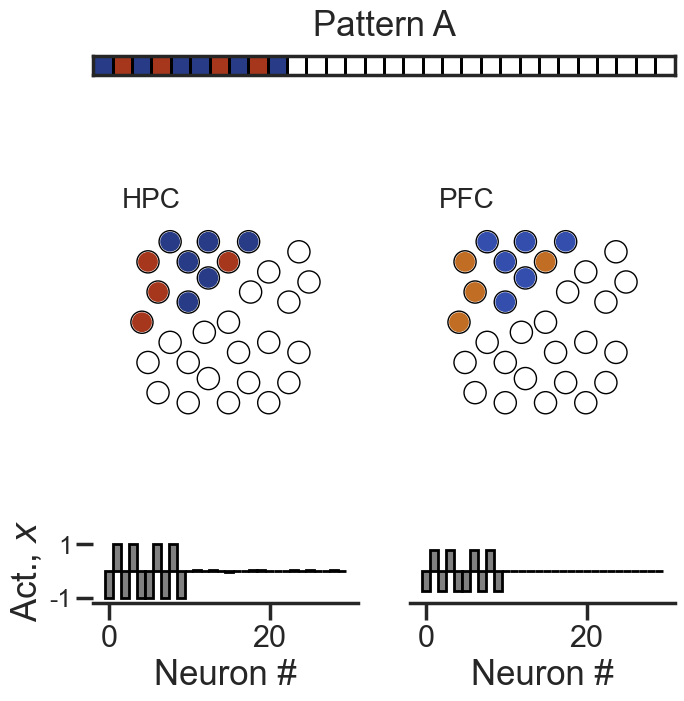

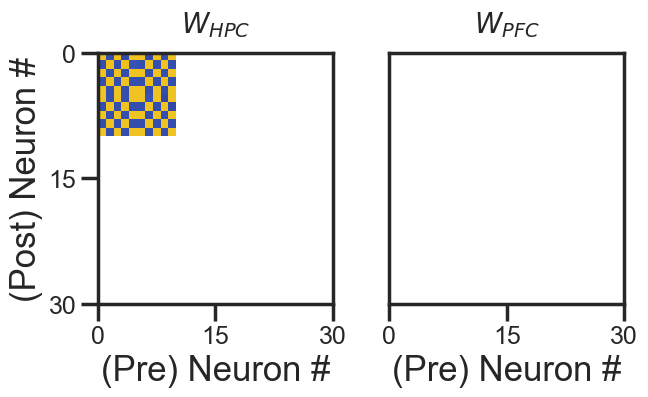

In [8]:
"""
Parameters
"""
n_HPC = 30
n_PFC = 30
n_total = n_HPC + n_PFC

learn_HPC = 0.45
decay_HPC = 0.55
learn_PFC = 0.06 
decay_PFC = 0
dt=0.01

"""
Initialize variables
"""
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[:n_HPC, :n_HPC] = np.random.normal(loc=0, scale=0.03, size=(n_HPC, n_HPC))
v1 = [i for i in range(n_HPC, n_total)] # indices of PFC neurons
v2 = [i for i in range(0, n_HPC)] # indices of HPc neurons
weights[v2,v1]=-1 # inhibitory PFC-to-HPC connections (post,pre)
weights[v1,v2]=0.5 # excitatory HPC-to-PFC connections (post,pre)

# Firing rates
r =  np.zeros(n_total)

# External input
P = np.array([-1, 1, -1,  1, -1,-1, 1, -1,  1, -1]) # pattern A
P_zeros = np.zeros(20)
P = np.concatenate((P, P_zeros)) # external input acting on one region
print('pattern to store:', P)
Pattern_A = np.copy(P) 
P=np.concatenate((P,P)) # external input acting on full HPC-PFC network

"""
Run simulation
"""
r_final, weights_awake_A, *_ = run_awake(r, weights, P)

r_final_HPC = r_final[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r_final[n_HPC:].reshape(1,n_HPC)


"""
Plots
"""
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set(style='white')
sns.set_style('ticks')
sns.set_context('poster')


# Figure 1 a)
fig = plt.figure(figsize=(7.5, 7.5))
grid = plt.GridSpec(3, 2, hspace=1, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input(Pattern_A, 'Pattern A', cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC',  r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x, r_final_HPC, ax=ax_bar_hpc, ylabel=True)


# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)


# Adjust layout and save the figure
plt.savefig('Figure1_a.png', dpi=600, transparent=True)
plt.show

# Figure 1 b)
fig = plt.figure(figsize=(7, 4.5))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights_awake_A[:n_HPC, :n_HPC], '$W_{HPC}$', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights_awake_A[n_HPC:, n_HPC:], '$W_{PFC}$', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure1_b.png', dpi=600, transparent=True)
plt.show()


#### Pattern A - Sleeping stage

Sleep cycle 0
Sleep cycle 1
Sleep cycle 2
Sleep cycle 3
Sleep cycle 4
Sleep cycle 5
Sleep cycle 6


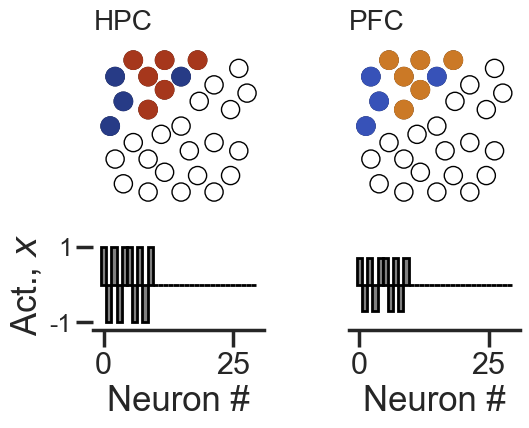

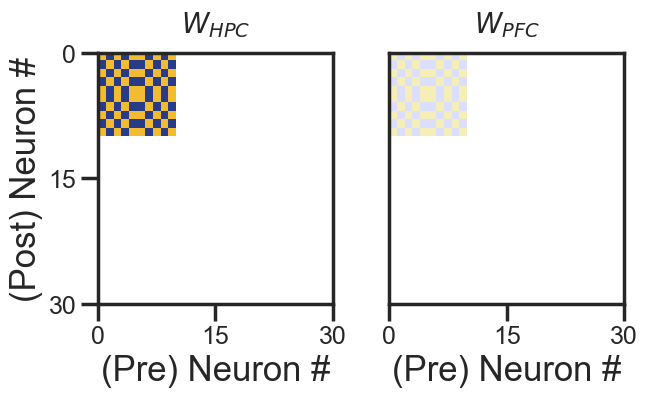

In [9]:
weights = np.copy(weights_awake_A) # save HPC and PFC connectivity at end of awake stage, after encoding pattern A

"""
Run simulation
"""
r_final, weights_sleep_A = run_sleep(weights, 'Figure1_c1.png', 'Figure1_c2.png')

r_final_HPC = r_final[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r_final[n_HPC:].reshape(1,n_HPC)


"""
Plots
"""
# Figure 1 c3)
fig = plt.figure(figsize=(5.5, 5))
grid = plt.GridSpec(2, 2, hspace=-0.3,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

ax_rnn_hpc = fig.add_subplot(grid[0, 0])
plot_RNN('HPC', r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[0, 1])
plot_RNN('PFC', r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
ax_bar_hpc = fig.add_subplot(grid[1, 0])
bar_activity(x, r_final_HPC, ax=ax_bar_hpc, ylabel=True)

# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[1, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)

# Adjust layout and save the figure
plt.savefig('Figure1_c3.png', dpi=600, transparent=True,  bbox_inches='tight')
plt.show


# Figure 1 d)
fig = plt.figure(figsize=(7, 4.5))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights_sleep_A[:n_HPC, :n_HPC], '$W_{HPC}$', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights_sleep_A[n_HPC:, n_HPC:], '$W_{PFC}$', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure1_d.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()


### Recall pattern A (Figure S2)

'Argument' for recall: activity of all units of engram to be >=0.2

C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


<function matplotlib.pyplot.show(close=None, block=None)>

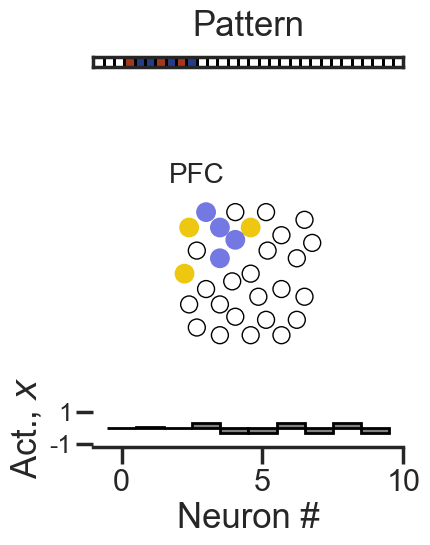

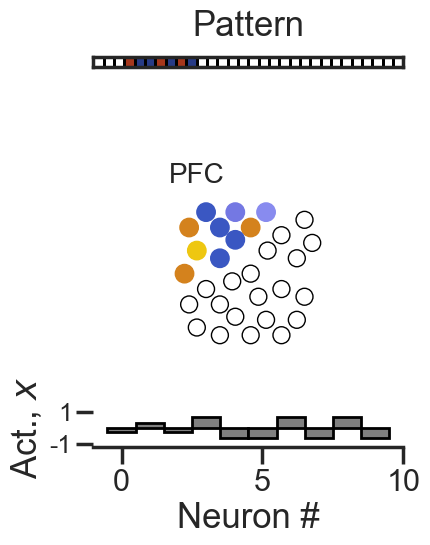

In [10]:
"""
Initialize variables
"""
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[n_HPC:,n_HPC:] = weights_sleep_A[n_HPC:,n_HPC:] # set weights of PFC to trained weights. 

# Firing rates
r =  np.zeros(n_total)

#External input
I = np.array([0, 0, 0,  1, -1,-1, 1, -1,  1, -1]) # incomplete pattern A
I_zeros = np.zeros(20)
I = np.concatenate((I, I_zeros)) # external input projecting to one region
Incomplete_pattern = np.copy(I)
I=np.concatenate((I,I)) # total external input acting on the full network

i=0

"""
Run simulation
"""
while True:  

    # Plot neural activity of PFC shortly after receiving external input to show which neurons are targeted by incomplete pattern clearly
    if i==90: 

        r_init_HPC = r[:n_HPC].reshape(1,n_HPC)
        r_init_PFC = r[n_HPC:].reshape(1,n_HPC)
        
        fig = plt.figure(figsize=(4, 6))
        grid = plt.GridSpec(3, 1, hspace=0.5, height_ratios=[2, 2, 0.5])
        
        ax_input = fig.add_subplot(grid[0, 0])
        plot_input(Incomplete_pattern, 'Pattern', cmap, ax=ax_input)
                
        ax_rnn_pfc = fig.add_subplot(grid[1, 0])
        plot_RNN('PFC', r_init_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

        # Bar graph with states for PFC
        ax_bar_pfc = fig.add_subplot(grid[2, 0])
        bar_activity(x[:10],r_init_PFC[0,:10], ax=ax_bar_pfc)

        # Adjust layout and save the figure
        plt.savefig('FigureSup1_a.png', dpi=600, transparent=True,  bbox_inches='tight')
        plt.show
 
        
    r_new = r + dt*hopfield(r, weights, I, n_HPC)
    
    if i>7600:
        break
        
    i+=1
    r = r_new

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)


"""
Plots
"""
# Figure Sup1
fig = plt.figure(figsize=(4, 6))
grid = plt.GridSpec(3, 1, hspace=0.5,height_ratios=[2, 2, 0.5])

ax_input = fig.add_subplot(grid[0, :])
plot_input(Incomplete_pattern, 'Pattern', cmap, ax=ax_input)

ax_rnn_pfc = fig.add_subplot(grid[1, 0])
plot_RNN('PFC', r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 0])
bar_activity(x[:10],r_final_PFC[0,:10], ax=ax_bar_pfc)

# Adjust layout and save the figure
plt.savefig('FigureSup1_b.png', dpi=600, transparent=True,  bbox_inches='tight')
plt.show


### Consolidation of novel memory pattern relies on hippocampal replay during sleep (Figure 2)


#### (Novel) Pattern B - Awake stage

New pattern B: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1. -1.  1.  0. -1.  0.
  0. -1.  0.  1.  0.  1.  0.  0.  0.  0. -1.  1.]


C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


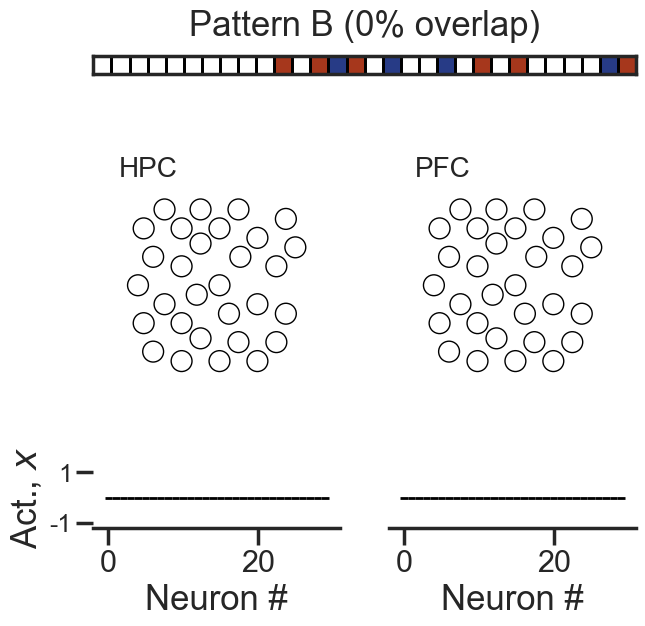

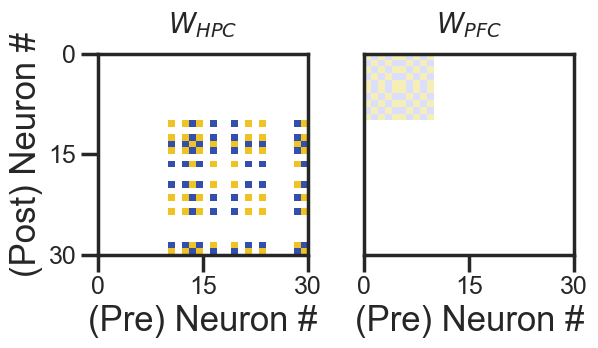

In [11]:
"""
Initialize variables
"""

# Connectivity matrix
weights = np.zeros((n_total, n_total)) # create connectiviy matrix of zeros
#weights[:n_HPC, :n_HPC] = np.random.normal(loc=0, scale=0.03, size=(n_HPC, n_HPC)) # start HPC with random connectivity
weights[n_HPC:,n_HPC:] = weights_sleep_A[n_HPC:,n_HPC:] # set connectivity of PFC to weights storing pattern A
weights[v2,v1]=-1  # inhibitory PFC-to-HPC connections
weights[v1,v2]=0.5 # excitatory HPC-to-PFC connections

# Firing rates
r =  np.zeros(n_total)

# New pattern overlaping by 0% with A
I = get_overlap_array(Pattern_A, 0) # external input projecting to one region
print('New pattern B:', I)
Pattern_B0 = np.copy(I)
I=np.concatenate((I,I)) # external input acting on HPC-PFC network

"""
Run simulation
"""
r_final, weights_awake_B0,*_ = run_awake(r, weights, I)

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)

"""
Plots
"""
# Figure 2 a)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input(Pattern_B0, 'Pattern B (0% overlap)', cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)


# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)

# Adjust layout and save the figure
plt.savefig('Figure2_a.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show

# Figure 1 b)
fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights(weights_awake_B0[:n_HPC, :n_HPC], '$W_{HPC}$', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights(weights_awake_B0[n_HPC:, n_HPC:], '$W_{PFC}$', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure2_b.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()



#### (Novel) Pattern B - Sleeping stage

Sleep cycle 0
Sleep cycle 1
Sleep cycle 2
Sleep cycle 3
Sleep cycle 4
Sleep cycle 5
Sleep cycle 6


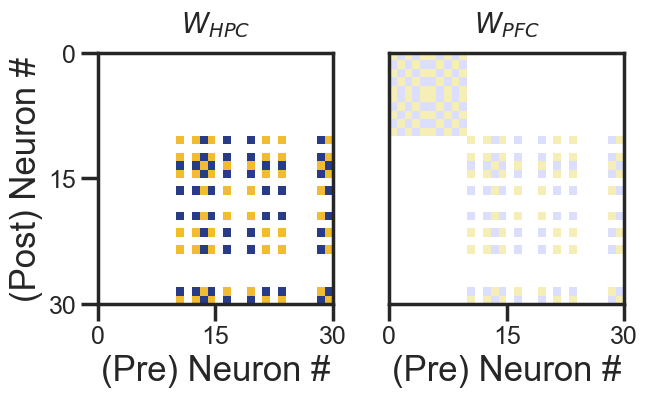

In [12]:

"""
Run simulation
"""
r_final, weights_sleep_B0 = run_sleep(weights_awake_B0, 'Figure2_b2_endREM.png', 'Figure2_b2_endNREM.png')

r_final_HPC = r_final[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r_final[n_HPC:].reshape(1,n_HPC)

"""
Plots
"""
# Figure 2 b2)
fig = plt.figure(figsize=(7, 4.5))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights_sleep_B0[:n_HPC, :n_HPC], '$W_{HPC}$', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights_sleep_B0[n_HPC:, n_HPC:], '$W_{PFC}$', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure2_b2.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()



### Familiar pattern is quickly stored during wakefulness (Figure 3)

#### (Familiar) pattern B - Awake stage


New pattern B: [ 0.  1. -1.  1. -1. -1.  1. -1.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


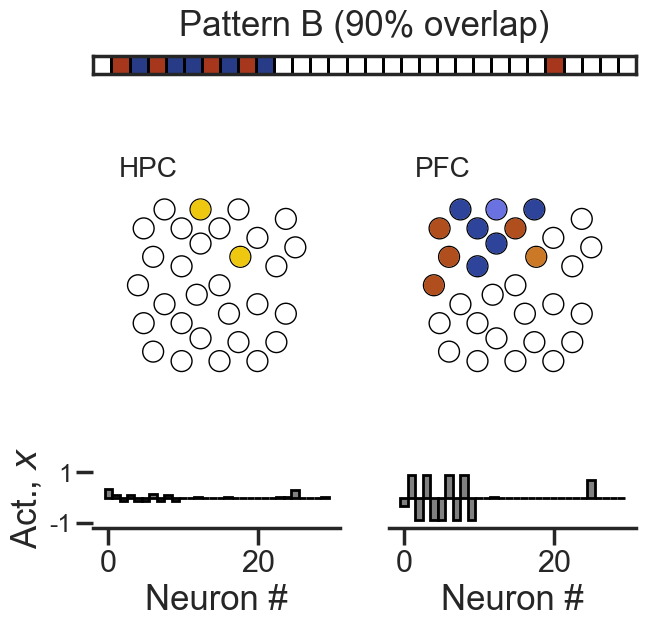

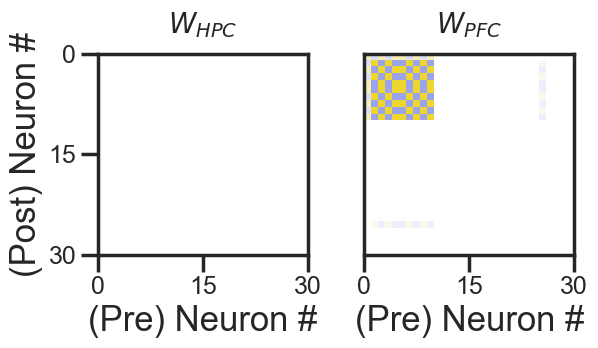

In [13]:
"""
Initialize variables
"""

# Connectivity matrix
weights = np.zeros((n_total, n_total)) # create connectiviy matrix of zeros
weights[:n_HPC, :n_HPC] = np.random.normal(loc=0, scale=0.03, size=(n_HPC, n_HPC)) # start HPC with random connectivity
weights[n_HPC:,n_HPC:] = weights_sleep_A[n_HPC:,n_HPC:] # set connectivity of PFC to weights storing pattern A
weights[v2,v1]=-1  # inhibitory PFC-to-HPC connections
weights[v1,v2]=0.5 # excitatory HPC-to-PFC connections

# Firing rates
r =  np.zeros(n_total)

# New pattern overlaping by 90% with A
I = get_overlap_array(Pattern_A, 0.9) # external input projecting to one region
print('New pattern B:', I)
Pattern_B90 = np.copy(I)
I=np.concatenate((I,I)) # external input acting on HPC-PFC network


"""
Run simulation
"""
r_final, weights_awake_B90,*_ = run_awake(r, weights, I)

r_final_HPC = r_final[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r_final[n_HPC:].reshape(1,n_HPC)

"""
Plots
"""
# Figure 3 a)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input(Pattern_B90, 'Pattern B (90% overlap)', cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)


# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)

# Adjust layout and save the figure
plt.savefig('Figure3_a1.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show

# Figure 3 b)
fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights_awake_B90[:n_HPC, :n_HPC], '$W_{HPC}$', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights_awake_B90[n_HPC:, n_HPC:], '$W_{PFC}$', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure3_a2.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()


#### (Familiar) pattern B - Sleeping stage

Sleep cycle 0
Sleep cycle 1
Sleep cycle 2
Sleep cycle 3
Sleep cycle 4
Sleep cycle 5
Sleep cycle 6


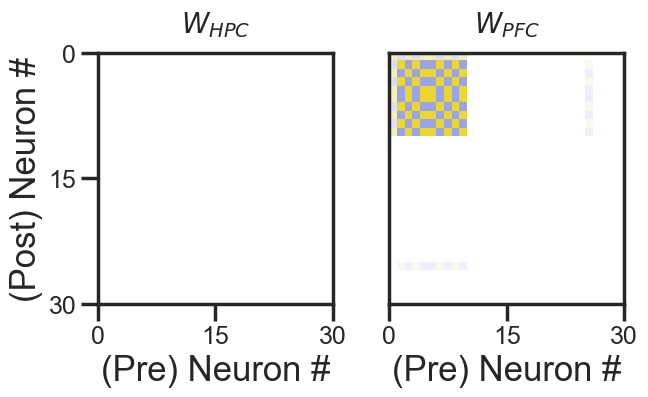

In [14]:
"""
Run simulation
"""
r_final, weights_sleep_B90 = run_sleep(weights_awake_B90, 'Figure3_b1_endREM.png', 'Figure3_b1_endNREM.png')

r_final_HPC = r_final[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r_final[n_HPC:].reshape(1,n_HPC)

"""
Plots
"""
# Figure 2 b2)
fig = plt.figure(figsize=(7, 4.5))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights_sleep_B90[:n_HPC, :n_HPC], '$W_{HPC}$', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights_sleep_B90[n_HPC:, n_HPC:], '$W_{PFC}$', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure3_b2.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()


### Differential role for HPC and PFC in the encoding of familiar inputs (Figure 4)

#### No HPC-to-PFC excitation

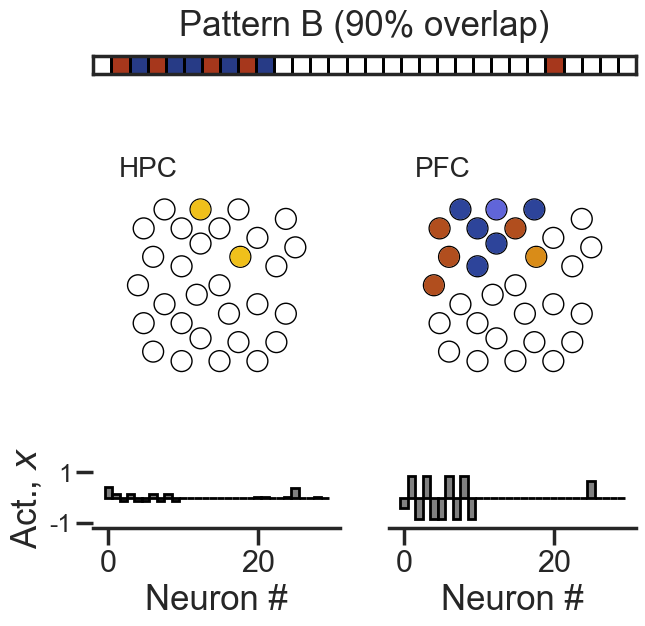

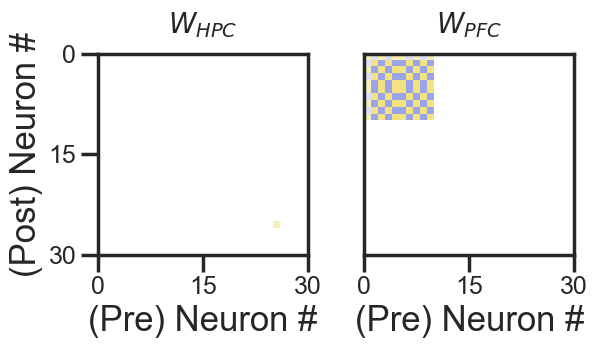

In [15]:
"""
Initialize variables
"""
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[:n_HPC, :n_HPC] = np.random.normal(loc=0, scale=0.03, size=(n_HPC, n_HPC)) # start HPC with random connectivity
weights[n_HPC:,n_HPC:] = weights_sleep_A[n_HPC:,n_HPC:] # set connectivity of PFC to weights storing pattern A
weights[v2,v1]=-1 # PFC-to-HPC connections
weights[v1,v2]=0.0 # HPC-to-PFC connections

# Firing rates
r =  np.zeros(n_total)

# Pattern B, 90% overlap (same as before)
I=np.concatenate((Pattern_B90, Pattern_B90)) # external input acting on HPC-PFC network

"""
Run simulation
"""
r_final, weights_awake_B90_noExc,*_ = run_awake(r, weights, I)

r_final_HPC = r_final[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r_final[n_HPC:].reshape(1,n_HPC)


"""
Plots
"""
# Figure 4 a1)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input(Pattern_B90, 'Pattern B (90% overlap)', cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)

# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)

# Adjust layout and save the figure
plt.savefig('Figure4_a1.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show

# Figure 4 a2)
fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights_awake_B90_noExc[:n_HPC, :n_HPC], '$W_{HPC}$', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights_awake_B90_noExc[n_HPC:, n_HPC:], '$W_{PFC}$', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure4_a2.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()


#### No PFC-to-HPC inhibition 

C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


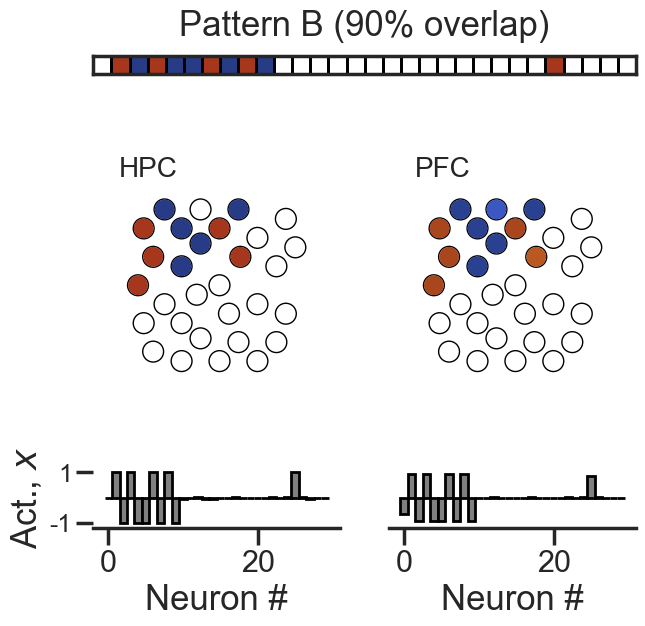

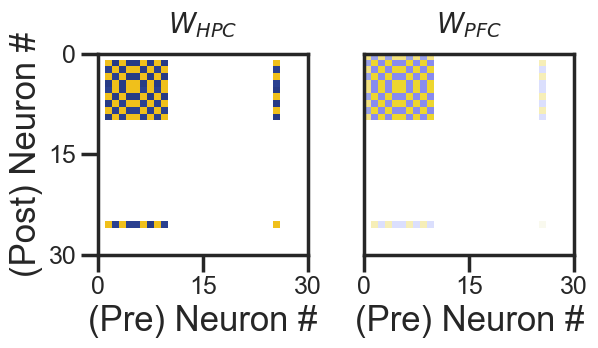

In [16]:
"""
Initialize variables
"""
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[:n_HPC, :n_HPC] = np.random.normal(loc=0, scale=0.03, size=(n_HPC, n_HPC)) # start HPC with random connectivity
weights[n_HPC:,n_HPC:] = weights_sleep_A[n_HPC:,n_HPC:] # set connectivity of PFC to weights storing pattern A
weights[v2,v1]=0 # PFC-to-HPC connections
weights[v1,v2]=0.5 # HPC-to-PFC connections

# Firing rates
r =  np.zeros(n_total)

# Pattern B, 90% overlap (same as before)
I=np.concatenate((Pattern_B90, Pattern_B90)) # external input acting on HPC-PFC network

"""
Run simulation
"""
r_final, weights_awake_B90_noIn,*_ = run_awake(r, weights, I)

r_final_HPC = r_final[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r_final[n_HPC:].reshape(1,n_HPC)

"""
Plots
"""
# Figure 4 b1)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input(Pattern_B90, 'Pattern B (90% overlap)', cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)


# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)

# Adjust layout and save the figure
plt.savefig('Figure4_b1.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show

# Figure 4 b2)
fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights_awake_B90_noIn[:n_HPC, :n_HPC], '$W_{HPC}$', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights_awake_B90_noIn[n_HPC:, n_HPC:], '$W_{PFC}$', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure4_b2.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()


### Generalization of results - examining changes in PFC plasticity and network activity (Figure 5)

First input with 0.1 overlap: [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  1.
  0.  0.  1.  0. -1.  0. -1.  1. -1.  0.  0. -1.]
Degree of overlap: 0.0
Degree of overlap: 0.1
Degree of overlap: 0.2
Degree of overlap: 0.3
Degree of overlap: 0.4
Degree of overlap: 0.5
Degree of overlap: 0.6
Degree of overlap: 0.7
Degree of overlap: 0.8
Degree of overlap: 0.9


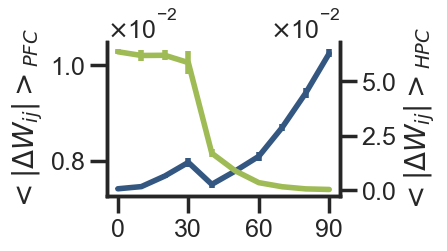

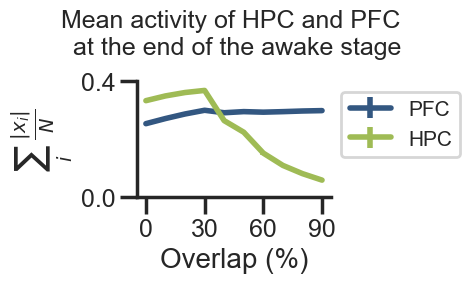

In [17]:
"""
Create a bunch of different patterns for each degree of overlap
"""
degree_of_overlap = np.around(np.arange(0, 1, 0.1), decimals=1) # array with fractions of overlap to evaluate (0, 0.1, 0.2, ...)
new_memories = {} # empty variable to store memory engram created for each degree of overlap simulation

p = 10  # Number of new inputs to generate

# For each degree of overlap, create 10 different patterns
for o in degree_of_overlap:
    inputs = []
    for _ in range(p):
        I = get_overlap_array(Pattern_A, o)  # Generate new input
        inputs.append(I)  # Store new input in the list
    new_memories[o] = inputs  # Store the list of inputs associated with 'o'
    
print("First input with 0.1 overlap:", new_memories[0.1][0])  


"""
Initialize variables
"""

# Sparseness 
sparse_HPC = np.zeros(len(degree_of_overlap))
sparse_PFC = np.zeros(len(degree_of_overlap))

std_HPC = np.zeros(len(degree_of_overlap))
std_PFC = np.zeros(len(degree_of_overlap))

# Connectivity changes
mean_deltaW_PFC = np.zeros(len(degree_of_overlap))
std_deltaW_PFC = np.zeros(len(degree_of_overlap))

mean_deltaW_HPC = np.zeros(len(degree_of_overlap))
std_deltaW_HPC = np.zeros(len(degree_of_overlap))


# Loop through degrees of overlap
for n,o in enumerate(degree_of_overlap):
    
    print('Degree of overlap:', o)
    patterns = new_memories[o] # get all patterns for the degree of overlap 'o'

    av_fr_HPC=[] # to store average firing rate of HPC at the end of the encoding of each pattern
    av_fr_PFC=[] # to store average firing rate of PFC at the end of the encoding of each pattern

    av_deltaW_HPC=[]  # to store average changes in HPC connectivity during the encoding of each pattern
    av_deltaW_PFC = [] # to store average changes in PFC connectivity during the encoding of each pattern
    
    for p in range(len(patterns)): 

        # Initial connectivity
        weights = np.zeros((n_total, n_total))
        weights[n_HPC:,n_HPC:] = weights_sleep_A[n_HPC:,n_HPC:] # set weights of PFC to trained weights, with memory_A
        weights[v2,v1]=-1 # Inhibitory PFC-to-HPC
        weights[v1,v2]=0.5 # Excitatory HPC-to-PFC

        # Initial firing rates
        r =  np.zeros(n_total)

        # Pattern to be encoded
        I = patterns[p] # external input projecting to one region
        I=np.concatenate((I,I)) # external input acting on the HPC-PFC network

        r_final, weights_awake_gen, av_fr_HPC, av_fr_PFC, av_deltaW_HPC, av_deltaW_PFC = run_awake(r, weights, I, 
                                                                                                   av_fr_HPC, av_fr_PFC, 
                                                                                                   av_deltaW_HPC, av_deltaW_PFC,
                                                                                                   sparseness=True, connectivity=True)

    # Compute mean activity of HPC and PFC at the end of the awake stage for each degree of overlap
    sparse_HPC[n]=np.mean(av_fr_HPC)  # average HPC activity over 10 patterns for each degree of overlap
    std_HPC[n]=np.std(av_fr_HPC)
    sparse_PFC[n]=np.mean(av_fr_PFC) # average PFC activity over 10 patterns for each degree of overlap
    std_PFC[n]=np.std(av_fr_PFC)

    # Compute mean HPC and PFC connectivity changes during the awake stage for each degree of overlap
    mean_deltaW_PFC[n]=np.mean(av_deltaW_PFC) # mean over 10 simulations for a degree of overlap 'o'
    std_deltaW_PFC[n]=np.std(av_deltaW_PFC)    
    mean_deltaW_HPC[n]=np.mean(av_deltaW_HPC) # mean over 10 simulations for a degree of overlap 'o'
    std_deltaW_HPC[n]=np.std(av_deltaW_HPC) 
        
"""
Plots
"""
from scipy.stats import gaussian_kde
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

params = {
   'axes.labelsize': 20,
   'legend.fontsize': 20,
   'xtick.labelsize': 18,
   'ytick.labelsize': 18,
    'lines.linewidth': 2,
   'figure.figsize': [3, 3]
   }

plt.rcParams.update(params)

# Figure 5a)
plt.figure(figsize=(3, 2))

# Primary y-axis (left)
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)  # Hide the top spine
ax1.errorbar(degree_of_overlap * 100, mean_deltaW_PFC, yerr=std_deltaW_PFC, color='#335781', linewidth=4)
ax1.set_ylabel(r'$<|\Delta W_{ij}|>_{PFC}$', fontsize=20)

# Secondary y-axis (right)
ax2 = ax1.twinx()
ax2.spines['top'].set_visible(False)  # Hide the top spine
ax2.errorbar(degree_of_overlap * 100, mean_deltaW_HPC, yerr=std_deltaW_HPC, color='#9FBB55', linewidth=4)
ax2.set_ylabel(r'$<|\Delta W_{ij}|>_{HPC}$', fontsize=20)

plt.xlabel('Overlap (%)')
plt.xticks([0, 30, 60, 90])

# Format y-axis ticks in scientific notation
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Set the power limits for scientific notation
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

plt.savefig('Changes_connectivity.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()


# Figure 5b)
plt.figure(figsize=(2.5,1.5))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.errorbar(degree_of_overlap*100,sparse_PFC, yerr=std_PFC, color='#335781', linewidth=4, label='PFC')
plt.errorbar(degree_of_overlap*100,sparse_HPC, yerr=std_HPC, color='#9FBB55', linewidth=4, label='HPC')
plt.xticks([0,30,60,90])
plt.yticks([0,0.4])
plt.legend(bbox_to_anchor=(1, 1), fontsize=15)
plt.ylabel(r'$\sum_i$ $\frac{|x_i|}{N}$', fontsize=20)
plt.xlabel('Overlap (%)')
plt.title('Mean activity of HPC and PFC \n at the end of the awake stage', pad=20, fontsize=18)
plt.savefig('Sparssity_index.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()


# Supplementary Figures of Guerreiro and Clopath (2024)

### Examining activity of HPC and PFC neurons targeted by a pattern B overlapping by 0 and 90% with A (Figure S4)

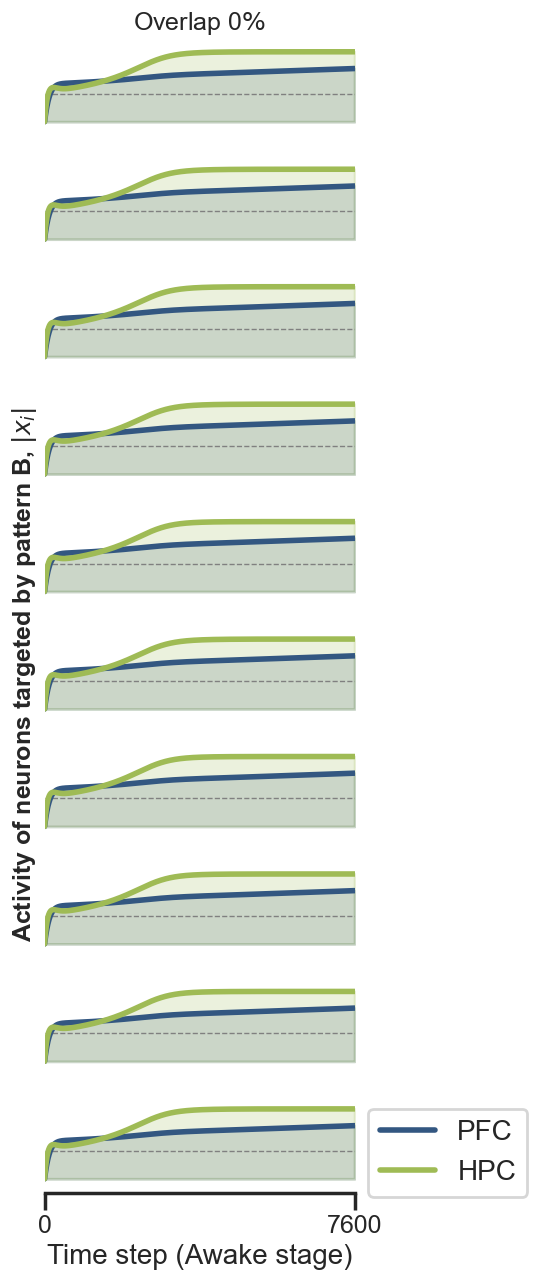

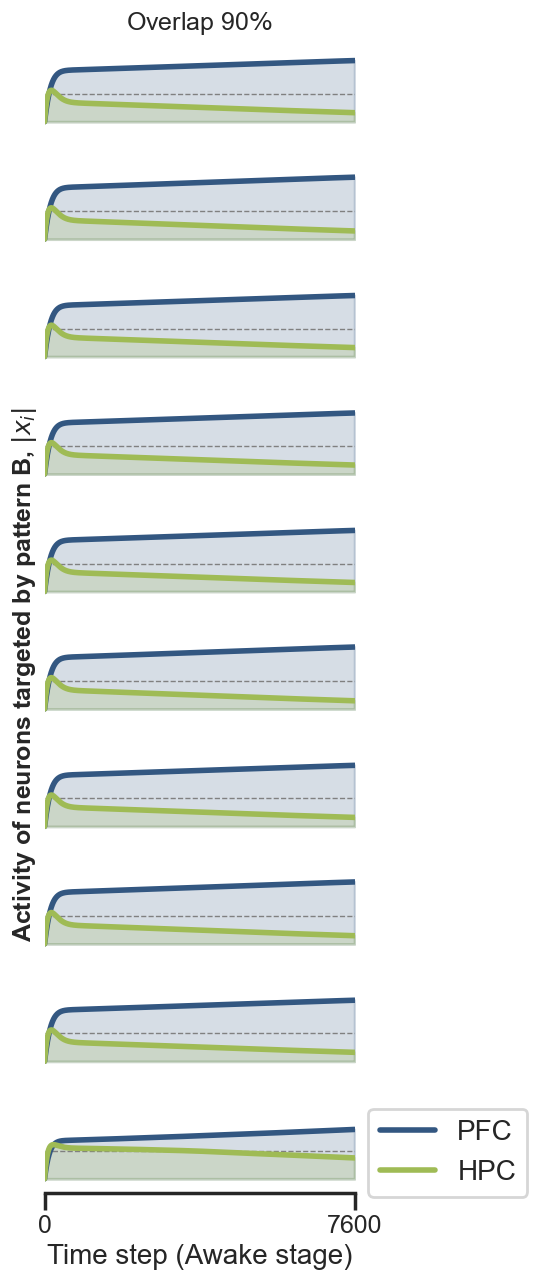

In [18]:
def plot_FigS2(r_total, targeted_neurons, o):
    abs_r_total = np.abs(r_total)
    
    fig, ax = plt.subplots(10, 1, figsize=(4,15))
    
    for j,n in enumerate(targeted_neurons):
        iterations = np.arange(len(r_total[n]))
    
        ax[j].spines['top'].set_visible(False)
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['left'].set_visible(False)
        ax[j].xaxis.tick_bottom()
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j].set_ylim([-0.2, 1.2])
        ax[j].set_xlim([0,7600])
        ax[j].axhline(y=0.4, color='grey', linestyle='--', linewidth=1)
        ax[j].plot(abs_r_total[n+30][:], color='#335781', linewidth=4, label='PFC')
        ax[j].fill_between(iterations, abs_r_total[n+30][:], 0, alpha=0.2, color='#335781')
        ax[j].plot(abs_r_total[n][:], color='#9FBB55', linewidth=4, label='HPC')
        ax[j].fill_between(iterations, abs_r_total[n][:], 0, alpha=0.2, color='#9FBB55')
        if j==5:
            ax[j].set_ylabel(f'Activity of neurons targeted by pattern B, $|x_i|$', fontsize=18, fontweight='bold')
        if j==0:
            ax[j].set_title(f'Overlap {int(o*100)}$\%$', fontsize=18)
        if j!=9:
            ax[j].spines['bottom'].set_visible(False)
        else:
            ax[j].set_xlabel('Time step (Awake stage)')
            ax[j].set_xticks([0,7600])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig(f'inputBneurons_{o}overlap.png', bbox_inches='tight', dpi=600, transparent=True)
    plt.show()

# Compute and plot firing rate traces of HPC and PFC neurons targeted by a pattern B overlapping by 0 and 90% with A
for o in [0.0,0.9]:

    # get all patterns for degree of overlap 'o' (computed previously)
    patterns = new_memories[o] 

    # Initial connectivity
    weights = np.zeros((n_total, n_total))
    weights[n_HPC:,n_HPC:] = weights_sleep_A[n_HPC:, n_HPC:] # set weights of PFC to trained weights, with memory_A
    weights[v2,v1]=-1 # Inhibitory PFC-to-HPC
    weights[v1,v2]=0.5 # Excitatory HPC-to-PFC

    # Initial firing rates
    r =  np.zeros(n_total)
    r_total = []

    # External input
    I = patterns[0] # external input projecting to one region
    targeted_neurons = np.nonzero(I)[0] # neurons targeted by pattern B, i.e. neurons encoding pattern B
    I=np.concatenate((I,I)) # external input acting on HPC-PFC network

    #run simulation
    i=0

    while True: 

        weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
        weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

        r_new = r + dt*hopfield(r, weights, I, n_HPC)
        r_total.append(r)

        if i>7600: # end of the awake stage
            r_total = list(zip(*r_total))
            plot_FigS2(r_total, targeted_neurons, o)
                
            break
                  
        i+=1
        r = r_new
        

### Computing the recurrent activity (recurrency) in PFC and density distribution of HPC and PFC activity during encoding of a pattern B overlapping by 0-90% with A (Figure S5)

Degree of overlap: 0.0
Degree of overlap: 0.1
Degree of overlap: 0.2
Degree of overlap: 0.3
Degree of overlap: 0.4
Degree of overlap: 0.5
Degree of overlap: 0.6
Degree of overlap: 0.7
Degree of overlap: 0.8
Degree of overlap: 0.9


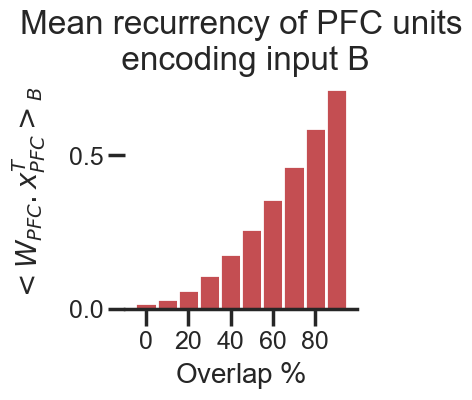

C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

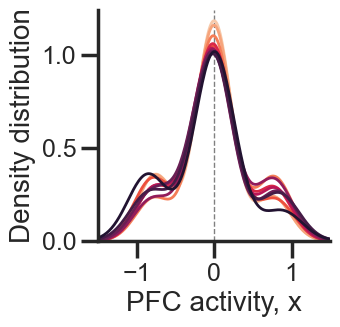

In [19]:
recurrency = {} # empty dict to store mean recurrent activity in PFC
firing_rates = {} # empty dict to store firing rate density distribution

for o in degree_of_overlap:
    
    print('Degree of overlap:', o)
    
    # Initial connectivity
    weights = np.zeros((n_total, n_total))
    weights[n_HPC:,n_HPC:] = weights_sleep_A[n_HPC:, n_HPC:] # set weights of PFC to trained weights, with memory_A
    weights[v2,v1]=-1 # Inhibitory PFC-to-HPC
    weights[v1,v2]=0.5 # Excitatory HPC-to-PFC

    # Initial firing rate
    r =  np.zeros(n_total)
    r_total=[]

    # External input
    I = new_memories[o][0] # external input projecting to one region
    targeted_neurons = np.nonzero(I)[0] # indices of neurons targeted by pattern B 
    I=np.concatenate((I,I)) # total external input acting on HPC-PFC network

    # Run simulation
    i=0

    while i<7600: 
        weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
        weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

        r_new = r + dt*hopfield(r, weights, I, n_HPC)
        r_total.append(r)
        
        if i==800: # calculate recurrent PFC activity in beginning of encoding
            recurrent_activity = weights[n_HPC:, n_HPC:]@r[n_HPC:]
            recurrency[o]=np.abs(recurrent_activity[targeted_neurons])
        
        i+=1
        r = r_new
    firing_rates[o]=r

"""
Plots
"""
# Figure S5 a)
# Calculate average PFC recurrent activity
mean_values = [np.mean(eval(f"recurrency[{o}]")) for o in degree_of_overlap]
categories = ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90']

# Create a bar graph with the mean values and customize the plot
plt.bar(range(len(categories)), mean_values, color='r', width=1)
plt.xticks(range(0, len(categories), 2), categories[::2])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom=True)
plt.yticks([0.0, 0.5])

plt.title('Mean recurrency of PFC units\n encoding input B')
plt.xlabel('Overlap $\%$')
plt.ylabel('$<W_{PFC}.x^T_{PFC}>_B$', labelpad=15)
plt.savefig('Recurrency.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()


# Figure S5 b)
fig, ax = plt.subplots()  # Create a figure and Axes object

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove the left and bottom ticks
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1) 
for n,o in enumerate(degree_of_overlap):
    color = sns.color_palette("rocket_r", 10)[n]  # Select color from Seaborn palette
    sns.kdeplot(firing_rates[o][n_HPC:], color=color)

plt.xlabel('PFC activity, x')
plt.xlim(-1.5, 1.5)
plt.yticks([0,0.5,1])
plt.ylabel('Density distribution')
plt.savefig('Sparseness_PFC.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()

## Testing linking and pattern separation of patterns A and B (for B overlapping by 0-90% with A; Figure S7)

In [20]:
'''
Calculate final connectivity for different degrees of overlap, without sleep
'''
trained_weights_without_sleep = {} # dict to store weights at end of awake stage for each degree of overlap

for o in degree_of_overlap:
    print('Degree of overlap:', o)
    patterns = new_memories[o]  # Get all patterns for degree of overlap 'o'
    
    for p in range(len(patterns)):

        # Initial connectivity
        weights = np.zeros((n_total, n_total))
        weights[n_HPC:, n_HPC:] = weights_sleep_A[n_HPC:, n_HPC:]  # set weights of PFC to trained weights, with memory_A
        weights[v2, v1] = -1 # inhibitory PFC-to-HPC connections
        weights[v1, v2] = 0.5 # excitatory HPC-to-PFC connections

        # Initial firing rates
        r = np.zeros(n_total)

        # External input
        I = patterns[p] # External input projecting to one region
        I = np.concatenate((I, I)) # Total external input acting on HPC-PFC network

        # Run simulation
        r_final, weights_awake_B, *_ = run_awake(r, weights, I)
        
        trained_weights_without_sleep.setdefault(o, []).append(weights_awake_B)  # Store weights associated with 'o'

Degree of overlap: 0.0
Degree of overlap: 0.1
Degree of overlap: 0.2
Degree of overlap: 0.3
Degree of overlap: 0.4
Degree of overlap: 0.5
Degree of overlap: 0.6
Degree of overlap: 0.7
Degree of overlap: 0.8
Degree of overlap: 0.9


In [21]:
'''
Calculate final connectivity for different degrees of overlap, with sleep (following previous cell). 

In practice, this is what I previously called Consolidation (or sleep) phase
'''

v1 = [i for i in range(n_HPC, n_total)]
v2 = [i for i in range(0, n_HPC)]

trained_weights_with_sleep = {}

for o in degree_of_overlap:
    
    print('Degree of overlap:', o)
    
    for p in range(len(patterns)):
         
        print('Pattern #', p)
        
        # Connectivity at beginning of sleep for each degree of overlap
        weights = np.copy(trained_weights_without_sleep[o][p])

        # Run simulation (sleeping stage)
        r_final, weights_sleep_B = run_sleep(weights, plot_figs=False)

        trained_weights_with_sleep.setdefault(o, []).append(weights_sleep_B)

Degree of overlap: 0.0
Pattern # 0
Sleep cycle 0
Sleep cycle 1
Sleep cycle 2
Sleep cycle 3
Sleep cycle 4
Sleep cycle 5
Sleep cycle 6
Pattern # 1
Sleep cycle 0
Sleep cycle 1
Sleep cycle 2
Sleep cycle 3
Sleep cycle 4
Sleep cycle 5
Sleep cycle 6
Pattern # 2
Sleep cycle 0
Sleep cycle 1
Sleep cycle 2
Sleep cycle 3
Sleep cycle 4
Sleep cycle 5
Sleep cycle 6
Pattern # 3
Sleep cycle 0
Sleep cycle 1
Sleep cycle 2
Sleep cycle 3
Sleep cycle 4
Sleep cycle 5
Sleep cycle 6
Pattern # 4
Sleep cycle 0
Sleep cycle 1
Sleep cycle 2
Sleep cycle 3
Sleep cycle 4
Sleep cycle 5
Sleep cycle 6
Pattern # 5
Sleep cycle 0
Sleep cycle 1
Sleep cycle 2
Sleep cycle 3
Sleep cycle 4
Sleep cycle 5
Sleep cycle 6
Pattern # 6
Sleep cycle 0
Sleep cycle 1
Sleep cycle 2
Sleep cycle 3
Sleep cycle 4
Sleep cycle 5
Sleep cycle 6
Pattern # 7
Sleep cycle 0
Sleep cycle 1
Sleep cycle 2
Sleep cycle 3
Sleep cycle 4
Sleep cycle 5
Sleep cycle 6
Pattern # 8
Sleep cycle 0
Sleep cycle 1
Sleep cycle 2
Sleep cycle 3
Sleep cycle 4
Sleep cycle 5
S

In [22]:
'''
Recall of memory B WITHOUT SLEEP

For each degree of overlap, start network with respective trained_weights_without_sleep.
Calculate input that partially overlaps with memory B for each network connectivity state. 
Check how many PFC cells are activated at end of each simulation. 

'''

num_simulations = 10 # for each pattern and each degree of overlap, randomly select subset of neurons encoding pattern to be activated 50 times
indices_memoryA = np.where(np.logical_or(Pattern_A[:n_HPC] == -1, Pattern_A[:n_HPC] == 1))[0] # get indices of neurons encoding pattern A


for p in range(len(patterns)):
    
    # Initialize a list to store recalll_B dictionaries for each simulation
    recall_B_list = []
    recall_AB_list = []
    
    for j in range(num_simulations):
        recall_B = {}
        recall_AB = {}

        weights = np.zeros((n_total, n_total))

        for o in degree_of_overlap:
            weights[n_HPC:,n_HPC:] = trained_weights_without_sleep[o][p][n_HPC:, n_HPC:] # set weights of R2(PFC) to trained weights
            recall_units_B = []
            recall_units_AB = []
    
            for number_act_units in range(10):
                r = np.zeros(n_total)
                indices_memoryB = np.where(np.logical_or(new_memories[o][p] == -1, new_memories[o][p] == 1))[0]
                indices_memoryAB = np.concatenate((indices_memoryA, indices_memoryB))

                I = new_memories[o][p]
                new_I = get_recall_input(I, number_act_units)
                new_I = np.concatenate((new_I, new_I))

                i=0
                while True:  

                    r_new = r + dt*hopfield(r, weights, new_I, n_HPC)   
    
                    if i>7600:
                        count_B = sum(1 for idx in indices_memoryB if abs(r_new[idx+n_HPC]) > 0.2)
                        recall_units_B.append(count_B)
                                        
                        count_AB = sum(1 for idx in indices_memoryAB if abs(r_new[idx+n_HPC]) > 0.2)
                        recall_units_AB.append(count_AB)  
            
                        break
        
                    i+=1
                    r = r_new

                recall_B[o]=recall_units_B
                recall_AB[o]=recall_units_AB
            recall_B_list.append(recall_B)
            recall_AB_list.append(recall_AB)


   

In [23]:
mean_recall_B={}
std_recall_B={}

mean_recall_AB={}
std_recall_AB={}

for o in degree_of_overlap:
    recall_values_B = np.array([recall_B[o] for recall_B in recall_B_list])  # Combine arrays from all simulations
    mean_recall_B[o] = np.mean(recall_values_B, axis=0)  # Calculate mean along axis 0 (across simulations)
    std_recall_B[o] = np.std(recall_values_B, axis=0)   # Calculate std along axis 0 (across simulations)

    recall_values_AB = np.array([recall_AB[o] for recall_AB in recall_AB_list])  # Combine arrays from all simulations
    mean_recall_AB[o] = np.mean(recall_values_AB, axis=0)  # Calculate mean along axis 0 (across simulations)
    std_recall_AB[o] = np.std(recall_values_AB, axis=0)   # Calculate std along axis 0 (across simulations)
               

In [24]:
'''
Recall of memory B and AB WITH SLEEP

''' 

num_simulations = 10
indices_memoryA = np.where(np.logical_or(Pattern_A[:n_HPC] == -1, Pattern_A[:n_HPC] == 1))[0]

for p in range(len(patterns)):
    
    # Initialize a list to store recalll_B dictionaries for each simulation
    recall_B_list = []
    recall_AB_list = []
    for j in range(num_simulations):
        recall_B = {}
        recall_AB = {}

        weights = np.zeros((n_total, n_total))

        for o in degree_of_overlap:
            weights[n_HPC:,n_HPC:] = trained_weights_with_sleep[o][p][n_HPC:, n_HPC:] # set weights of R2(PFC) to trained weights
            recall_units_B = []
            recall_units_AB = []
    
            for number_act_units in range(10):
                r = np.zeros(n_total)
                indices_memoryB = np.where(np.logical_or(new_memories[o][p] == -1, new_memories[o][p] == 1))[0]
                indices_memoryAB = np.concatenate((indices_memoryA, indices_memoryB))

                I = new_memories[o][p]
                new_I = get_recall_input(I, number_act_units)
                new_I = np.concatenate((new_I, new_I))

                i=0
                while True:  

                    r_new = r + dt*hopfield(r, weights, new_I, n_HPC)   
    
                    if i>7600:
                        count_B = sum(1 for idx in indices_memoryB if abs(r_new[idx+n_HPC]) > 0.2)
                        recall_units_B.append(count_B)
                                        
                        count_AB = sum(1 for idx in indices_memoryAB if abs(r_new[idx+n_HPC]) > 0.2)
                        recall_units_AB.append(count_AB)        
            
                        break
        
                    i+=1
                    r = r_new

                recall_B[o]=recall_units_B
                recall_AB[o]=recall_units_AB
            recall_B_list.append(recall_B)
            recall_AB_list.append(recall_AB)
            

In [25]:
mean_recall_sleep_B={}
std_recall_sleep_B={}

mean_recall_sleep_AB={}
std_recall_sleep_AB={}

for o in degree_of_overlap:
    recall_values_B = np.array([recall_B[o] for recall_B in recall_B_list])  # Combine arrays from all simulations
    mean_recall_sleep_B[o] = np.mean(recall_values_B, axis=0)  # Calculate mean along axis 0 (across simulations)
    std_recall_sleep_B[o] = np.std(recall_values_B, axis=0)   # Calculate std along axis 0 (across simulations)

    recall_values_AB = np.array([recall_AB[o] for recall_AB in recall_AB_list])  # Combine arrays from all simulations
    mean_recall_sleep_AB[o] = np.mean(recall_values_AB, axis=0)  # Calculate mean along axis 0 (across simulations)
    std_recall_sleep_AB[o] = np.std(recall_values_AB, axis=0)   # Calculate std along axis 0 (across simulations)
               

In [26]:
"""
Computing 'Recall threshold'.

Calculate minimum number of neurons need to be activated to recall A+B (linking) or just B (recall B)
"""

recall_noSleep = []
recall_Sleep = []
linking_noSleep = []
linking_Sleep = []

for p in range(len(patterns)):

    recall_quantified_no_sleep = []

    for o in degree_of_overlap:
        indices = np.where(mean_recall_B[o]==10)[0]
    
        if len(indices)>0:
            recall_quantified_no_sleep.append(1/indices[0])
        else:
            recall_quantified_no_sleep.append(0)
    
    recall_noSleep.append(recall_quantified_no_sleep)
  

    recall_quantified_sleep = []

    for o in degree_of_overlap:
    
        indices = np.where(mean_recall_sleep_B[o]==10)[0]
    
        if len(indices)>0:
            recall_quantified_sleep.append(1/indices[0])
        else:
            recall_quantified_sleep.append(0)
            
    recall_Sleep.append(recall_quantified_sleep)
        
        
    linking_quantified_no_sleep = []

    for o in degree_of_overlap:
    
        indices = np.where(mean_recall_AB[o]==20)[0]
    
        if len(indices)>0:
            linking_quantified_no_sleep.append(1/indices[0])
        else:
            linking_quantified_no_sleep.append(0)
    linking_noSleep.append(linking_quantified_no_sleep)
    
        
    linking_quantified_sleep = []

    for o in degree_of_overlap:
    
        indices = np.where(mean_recall_sleep_AB[o]==20)[0]
    
        if len(indices)>0:
            linking_quantified_sleep.append(1/indices[0])
        else:
            linking_quantified_sleep.append(0)
            
    linking_Sleep.append(linking_quantified_sleep)

recall_noSleep_array = np.array(recall_noSleep)
mean_recall_noSleep = np.mean(recall_noSleep_array, axis=0)
std_recall_noSleep = np.std(recall_noSleep_array, axis=0)

recall_Sleep_array = np.array(recall_Sleep)
mean_recall_Sleep = np.mean(recall_Sleep_array, axis=0)
std_recall_Sleep = np.std(recall_Sleep_array, axis=0)

linking_noSleep_array = np.array(linking_noSleep)
mean_linking_noSleep = np.mean(linking_noSleep_array, axis=0)
std_linking_noSleep = np.std(linking_noSleep_array, axis=0)

linking_Sleep_array = np.array(linking_Sleep)
mean_linking_Sleep = np.mean(linking_Sleep_array, axis=0)
std_linking_Sleep = np.std(linking_Sleep_array, axis=0)

#### Plotting FigureS7 a) and b)

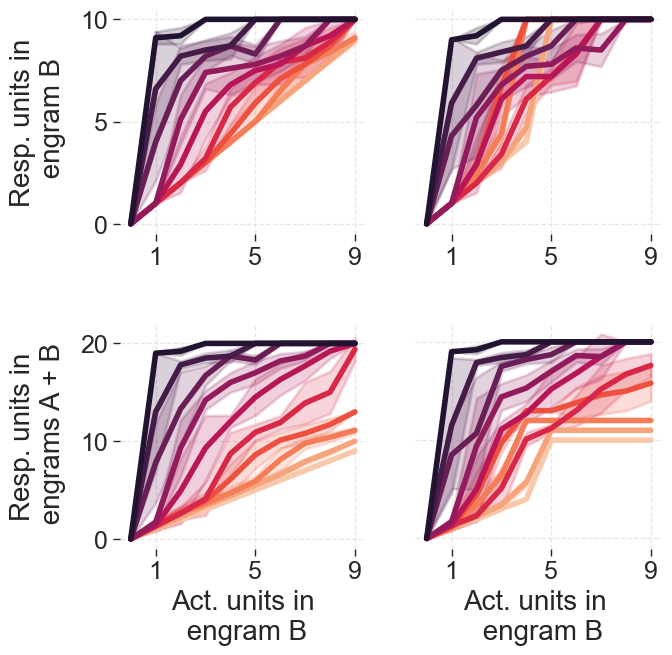

In [27]:
"""Linking and recall"""


params = {
   'axes.labelsize': 20,
   'legend.fontsize': 18,
   'xtick.labelsize': 18,
   'ytick.labelsize': 18,
   'axes.titlesize': 30, 
   'axes.titlepad': 10,
   'lines.linewidth': 2,
   'figure.figsize': [7, 6.5],
   'savefig.dpi': 600,
   'savefig.transparent': True
    }

plt.rcParams.update(params)

# Recall B, no sleep
fig = plt.figure()
plt.subplots_adjust(top=0.94,
                    #bottom=0.0,
                    hspace=0.4,
                    wspace=0.2)
ax1 = fig.add_subplot(2,2,1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.grid(linestyle='--', linewidth=0.9, color='0.9')
for n,o in enumerate(degree_of_overlap):
    x_range = range(len(mean_recall_B[o]))
    color = sns.color_palette("rocket_r", 10)[n]  # Select color from Seaborn palette
    ax1.plot(mean_recall_B[o], color=color, linewidth=4)
    ax1.fill_between(x_range,
        mean_recall_B[o] + std_recall_B[o],
        mean_recall_B[o] - std_recall_B[o],
        color=color,
        alpha=0.2
    )
  
#ax1.set_xlabel('Engram B')
ax1.set_xticks([1, 5, 9])
ax1.set_yticks([0, 5, 10])
ax1.set_ylabel('Resp. units in\n engram B', labelpad=10)
ax1.tick_params(width=1, length=5)
#legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#legend.set_title('% Overlap', prop={'size':20})



# Recall B, sleep
ax2 = fig.add_subplot(2,2,2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.yaxis.set_tick_params(left=False, labelleft=False)
ax2.get_xaxis().tick_bottom()
ax2.grid(linestyle='--', linewidth=0.9, color='0.9')
for n,o in enumerate(degree_of_overlap):
    color = sns.color_palette("rocket_r", 10)[n]  # Select color from Seaborn palette
    x_range = range(len(mean_recall_sleep_B[o]))
    ax2.plot(mean_recall_sleep_B[o], color=color, linewidth=4)
    ax2.fill_between(x_range,
        mean_recall_sleep_B[o] + std_recall_sleep_B[o],
        mean_recall_sleep_B[o] - std_recall_sleep_B[o],
        color=color,
        alpha=0.2
    )
  
#ax2.set_xlabel('Engram B')
ax2.set_xticks([1, 5, 9])
#ax2.set_yticks([0, 5, 10])
#ax2.set_ylabel('Engram B')
ax2.tick_params(width=1, length=5)


# Recall AB, no sleep
ax3 = fig.add_subplot(2,2,3)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.get_xaxis().tick_bottom()
ax3.get_yaxis().tick_left()
ax3.grid(linestyle='--', linewidth=0.9, color='0.9')
for n,o in enumerate(degree_of_overlap):
    color = sns.color_palette("rocket_r", 10)[n]  # Select color from Seaborn palette
    x_range = range(len(mean_recall_AB[o]))
    ax3.plot(mean_recall_AB[o], color=color, linewidth=4)
    ax3.fill_between(x_range,
        mean_recall_AB[o] + std_recall_AB[o],
        mean_recall_AB[o] - std_recall_AB[o],
        color=color,
        alpha=0.2
    )
  
ax3.set_xlabel('Act. units in\n engram B')
ax3.set_xticks([1, 5, 9])
ax3.set_yticks([0, 10, 20])
ax3.set_ylim([-1,22])
ax3.set_ylabel('Resp. units in\n engrams A + B', labelpad=10)
ax3.tick_params(width=1, length=5)

# Recall AB, sleep
ax4 = fig.add_subplot(2,2,4)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.get_xaxis().tick_bottom()
ax4.yaxis.set_tick_params(left=False, labelleft=False)
ax4.grid(linestyle='--', linewidth=0.9, color='0.9')
for n,o in enumerate(degree_of_overlap):
    color = sns.color_palette("rocket_r", 10)[n]  # Select color from Seaborn palette
    x_range = range(len(mean_recall_sleep_AB[o]))
    ax4.plot(mean_recall_sleep_AB[o], color=color, linewidth=4)
    ax4.fill_between(x_range,
        mean_recall_sleep_AB[o] + std_recall_sleep_AB[o],
        mean_recall_sleep_AB[o] - std_recall_sleep_AB[o],
        color=color,
        alpha=0.2
    )
  
ax4.set_xlabel('Act. units in \n engram B')
ax4.set_xticks([1, 5, 9])
#ax4.set_yticks([0, 10, 20])
#ax4.set_ylabel('Engram A + Engram B')
ax4.tick_params(width=1, length=5)
plt.savefig('Activated_vs_Responsive_cells.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()

#### Plotting Figure S7 c)

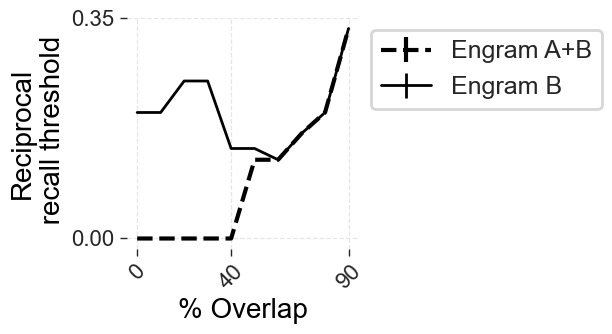

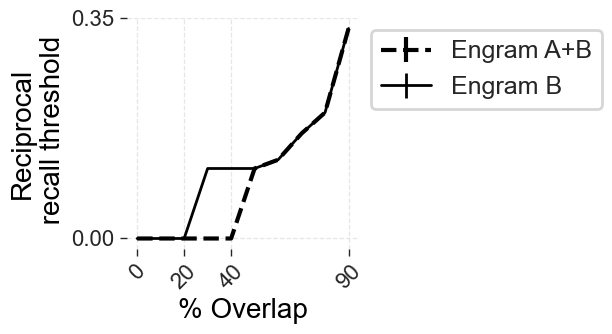

In [28]:
"""Linking and pattern separation"""


params = {
   'axes.labelsize': 20,
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16,
   'figure.figsize': [3, 3]
   }
plt.rcParams.update(params)

fig, ax1 = plt.subplots() 

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.get_xaxis().tick_bottom()
ax1.grid(linestyle='--', linewidth=0.9, color='0.9')
ax1.set_yticks([0.0, 0.5, 1.0])
ax1.set_ylabel('Reciprocal\n recall threshold', color = 'black') 
ax1.set_xlabel('% Overlap', color = 'black') 
ax1.tick_params(width=1, length=5)

ax1.errorbar(degree_of_overlap*100, mean_linking_Sleep, yerr=std_linking_Sleep,  color = 'black', linewidth=3, linestyle='--', label='Engram A+B')
ax1.errorbar(degree_of_overlap*100, mean_recall_Sleep, yerr=std_recall_Sleep,  color = 'black', linewidth=2, label='Engram B')

 
ax1.set_xticks([0,40, 90])
ax1.set_yticks([0,0.35])
ax1.set_xticklabels(ax1.get_xticks(), rotation=45)
 

ax1.legend(loc=0, bbox_to_anchor=(2.1, 1))
plt.savefig('Linking_vs_recall_plot2.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()



fig, ax1 = plt.subplots() 

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.get_xaxis().tick_bottom()
ax1.grid(linestyle='--', linewidth=0.9, color='0.9')
ax1.set_yticks([0.0, 0.5, 1.0])
ax1.set_ylabel('Reciprocal\n recall threshold', color = 'black') 
ax1.set_xlabel('% Overlap', color = 'black') 
ax1.tick_params(width=1, length=5)

ax1.errorbar(degree_of_overlap*100, mean_linking_noSleep, yerr=std_linking_noSleep,  color = 'black', linewidth=3, linestyle='--', label='Engram A+B')
ax1.errorbar(degree_of_overlap*100, mean_recall_noSleep, yerr=std_recall_noSleep,  color = 'black', linewidth=2, label='Engram B')

   
ax1.set_xticks([0,20, 40, 90])
ax1.set_yticks([0,0.35])
ax1.set_xticklabels(ax1.get_xticks(), rotation=45)


ax1.legend(loc=0, bbox_to_anchor=(2.1, 1))
plt.savefig('Linking_vs_recall_plot1.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()


#### Plotting Figure 6 c)
Based on recall threshold for A+B and just B, plot a bar graph showing, for increasing degrees of overlap, when memories are encoded during sleep an linked in PFC

C:\Users\Florencia\AppData\Local\Temp\ipykernel_35952\3357478325.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig('Separation_linking.png', bbox_inches='tight', dpi=600, transparent=True)
C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


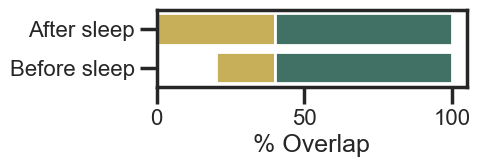

In [29]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [4, 1]
plt.rcParams["figure.autolayout"] = True

stage = ["Before sleep", "After sleep"]
# Data for the bottom bar
bottom_data = [20, 20, 60]
bottom_colors = ['white', '#C7AE58','#417165']

# Data for the top bar
top_data = [40, 60]
top_colors = ['#C7AE58', '#417165']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the bottom bar
ax.barh(stage[0], bottom_data[0], color=bottom_colors[0])
ax.barh(stage[0], bottom_data[1], left=bottom_data[0], color=bottom_colors[1])
ax.barh(stage[0], bottom_data[2], left=40, color=bottom_colors[2])



# Plot the top bar
ax.barh(stage[1], top_data[0], color=top_colors[0])
ax.barh(stage[1], top_data[1], left=top_data[0], color=top_colors[1])

plt.xlabel('% Overlap', fontsize=18)
#plt.legend([b1, b2], ["Separation", "Linking"], loc="upper right", bbox_to_anchor=(1.5, 1))
plt.savefig('Separation_linking.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()

## Compare HPC activity during encoding of an input C that overlaps by 20% with A and 20% with B, when A and B are linked or not (Figure S9)

#### 1) Link A and B (B overlaps by 80% with A)
Uncomment <code>I=np.array(...)</code> with 60% and 0% of overlap with A to get middle and right panel of Figure S9

Sleep cycle 0
Sleep cycle 1
Sleep cycle 2
Sleep cycle 3
Sleep cycle 4
Sleep cycle 5
Sleep cycle 6


C:\Users\Florencia\AppData\Local\Temp\ipykernel_35952\12562564.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Figure2_a.png', dpi=600, transparent=True, bbox_inches='tight')
C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


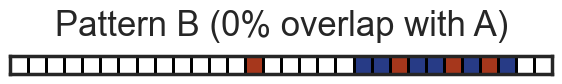

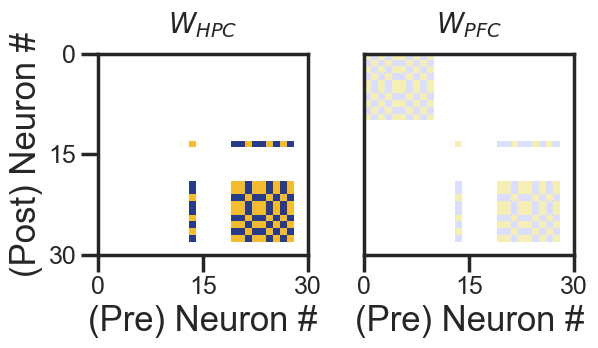

In [30]:
"""
Initialize variables
"""
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[n_HPC:,n_HPC:] = weights_sleep_A[n_HPC:, n_HPC:] # set weights of PFC to weights after consolidation of pattern A
weights[v2,v1]=-1 # inhibitory PFC-to-HPC connections
weights[v1,v2]=0.5 # excitatory HPC-to-PFC connections

# Firing rates
r =  np.zeros(n_total)

#External input
# Defining the external input as in below instead of using 'overlap' function gives us more control to get the specific level of overlap between all 3 inputs
#I = np.array([-1,  1., -1.,  1,  -1, -1.,  1., -1.,  0,  0., 0,  0.,  0.,  1,  0,  0.,  0.,  0.,
#  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]) # Input B 80% overlap with A

#I = np.array([-1,  1., -1,  1,  -1, -1.,  0, 0,  0,  0., 0,  0,  0.,  0,  0,  0.,  -1,  0.,
#  0.,  0.,  0.,  0.,  0.,  0,  0,  0.,  -1,  0.,  -1,  1]) # Input B 60% overlap with A

I = np.array([0,  0, 0,  0,  0, 0,  0, 0,  0,  0., 0,  0,  0.,  1,  0,  0.,  0,  0.,
  0.,  -1,  -1,  1,  -1,  -1,  1,  -1,  1,  -1,  0,  0]) # Input B 0% overlap with A

Pattern_B = np.copy(I)
I=np.concatenate((I,I)) # total external input acting on HPc-PFC network

"""
Run simulation
"""
r_end_awake, weights_awake_B, *_ = run_awake(r, weights, I)
r_final, weights_sleep_B = run_sleep(weights_awake_B, plot_figs=False)

r_final_HPC = r_final[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r_final[n_HPC:].reshape(1,n_HPC)

"""
Plots
"""
# Figure S9 a), left-top panel
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input(Pattern_B, 'Pattern B (0% overlap with A)', cmap, ax=ax_input)

# Adjust layout and save the figure
plt.savefig('Figure2_a.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show


fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights_sleep_B[:n_HPC, :n_HPC], '$W_{HPC}$', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights_sleep_B[n_HPC:, n_HPC:], '$W_{PFC}$', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure2_b.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()


#### 2) Input C arrives

[ 0  0  0  0  0  0  0  0  1 -1  0  1  1  1 -1 -1  0  0  0  0  0  0  0  0
  1  0  0  0 -1  1]
Sleep cycle 0
Sleep cycle 1
Sleep cycle 2
Sleep cycle 3
Sleep cycle 4
Sleep cycle 5
Sleep cycle 6


C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)
C:\Users\Florencia\AppData\Local\Temp\ipykernel_35952\1512606738.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Figure2_a.png', dpi=600, transparent=True, bbox_inches='tight')
C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


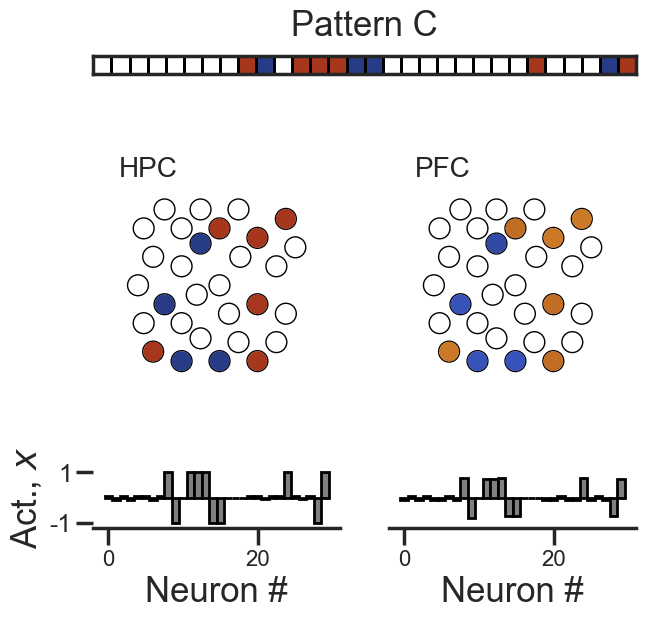

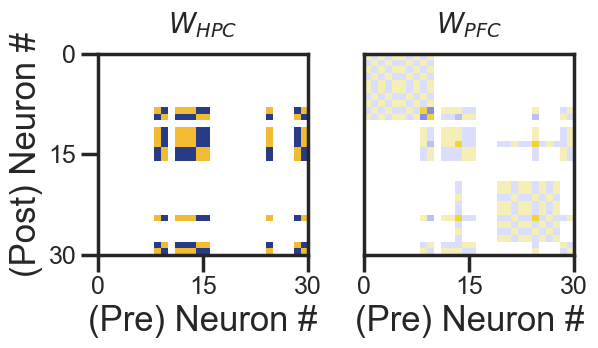

In [31]:
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[n_HPC:,n_HPC:] = weights_sleep_B[n_HPC:, n_HPC:] # set weights of R2(PFC) to trained weights
weights[v2,v1]=-1
weights[v1,v2]=0.5

# Firing rates
r =  np.zeros(n_total)

# External input C
I = np.array([0,0,0,0,0,0,0,0,1,-1,0,1,1,1,-1,-1,0,0,0,0,0,0,0,0,1,0,0,0,-1,1]) # Input C (20% overlap with A and 20% with B)
print(I)
Pattern_C = np.copy(I)
I=np.concatenate((I,I)) # total external input acting on HPC-PFC network

"""
Run simulation
"""
r_end_awake, weights_awake_C, *_ = run_awake(r, weights, I)
r_final, weights_sleep_C = run_sleep(weights_awake_C, plot_figs=False)

r_final_HPC = r_final[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r_final[n_HPC:].reshape(1,n_HPC)

"""
Plots
"""
# Figure S9 a), left-middle panel
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input(Pattern_C, 'Pattern C', cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)
 
# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)

# Adjust layout and save the figure
plt.savefig('Figure2_a.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show

fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights_awake_C[:n_HPC, :n_HPC], '$W_{HPC}$', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights_awake_C[n_HPC:, n_HPC:], '$W_{PFC}$', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
#plt.savefig('Figure2_b.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()


Are patterns A, B and C linked? 


C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)
C:\Users\Florencia\AppData\Local\Temp\ipykernel_35952\26869309.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('FigureSup1_b.png', dpi=600, transparent=True,  bbox_inches='tight')


<function matplotlib.pyplot.show(close=None, block=None)>

C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


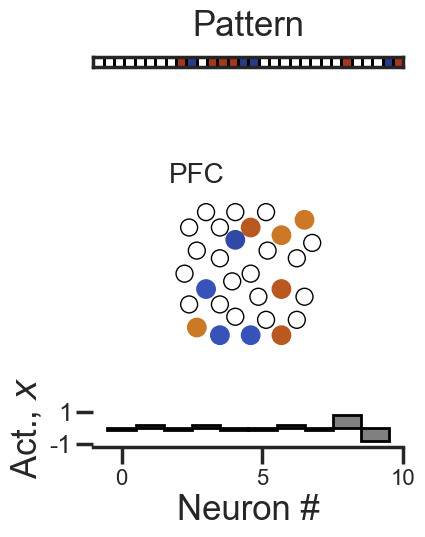

In [32]:
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[n_HPC:,n_HPC:] = weights_sleep_C[n_HPC:, n_HPC:] # set weights of R2(PFC) to trained weights

# Firing rates
r =  np.zeros(n_total)

# External input
# Use I defined before, i.e. pattern C input

"""
Run recall simulation
"""
i=0

while True:   
        
    r_new = r + dt*hopfield(r, weights, I, n_HPC)
    
    if i>7600:
        break  
        
    i+=1
    r = r_new

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)

 
"""
Plots
"""
fig = plt.figure(figsize=(4, 6))
grid = plt.GridSpec(3, 1, hspace=0.5,height_ratios=[2, 2, 0.5])

ax_input = fig.add_subplot(grid[0, 0])
plot_input(Pattern_C, 'Pattern', cmap, ax=ax_input)

ax_rnn_pfc = fig.add_subplot(grid[1, 0])
plot_RNN('PFC', r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 0])
bar_activity(x[:10],r_final_PFC[0,:10], ax=ax_bar_pfc)

# Adjust layout and save the figure
plt.savefig('FigureSup1_b.png', dpi=600, transparent=True,  bbox_inches='tight')
plt.show


### Examining interference of 2 patterns, B1 and B2, encoded consecutively during wakefulness wih and without PFC inhibition (Figure S11)
Patterns B1 and B2 both overlap by 405 with A, and 20% with each other

**1) Encoding of patterns B1 and B2**

Change <code>weights[v2,v1]</code> from -1 to 0 to exmaine the cases with or without PFC inhibition

C:\Users\Florencia\AppData\Local\Temp\ipykernel_35952\2430839851.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Pattern_B1.png', bbox_inches='tight', dpi=600, transparent=True)
C:\Users\Florencia\AppData\Local\Temp\ipykernel_35952\2430839851.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Pattern_B2.png', bbox_inches='tight', dpi=600, transparent=True)
C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


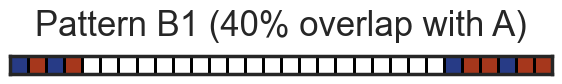

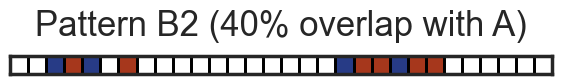

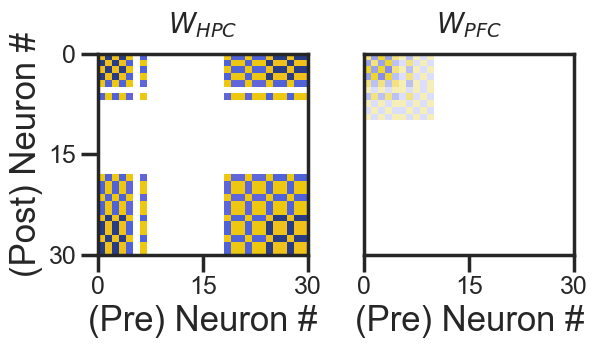

In [33]:
"""
Initialize variables
"""

# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[n_HPC:,n_HPC:] = weights_sleep_A[n_HPC:, n_HPC:] # set weights of PFC to trained weights with pattern A
weights[v2,v1]=0 # inhibitory PFC-to-HPC connections
weights[v1,v2]=0.5 # excitatory HPC-to-PFC connections

# Firing rates
r =  np.zeros(n_total)

# External inputs
I_1 = np.array([-1, 1, -1, 1, 0, 0, 0, 0, 0, 0, 0,0 , 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 1, 1, -1, 1, 1]) # pattern B1
Pattern_B1 = np.copy(I_1)
I_1=np.concatenate((I_1,I_1)) # total external input acting on the HPC-PFC network for first part of simulation

I_2 = np.array([0, 0, -1, 1, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 1, 1, -1, 1,1, 0, 0, 0, 0, 0, 0]) # pattern B2
Pattern_B2 = np.copy(I_2)
I_2=np.concatenate((I_2,I_2)) # total external input acting on the HPC-PFC network for the second part of simulation

"""
Run simulation
"""
# Awake Stage

# During wakefulness, the network starts by encoding  pattern B1, for 4900 time steps, followed by pattern B2 for 4100 time steps.
# The differences in the duration of presentation of the patterns B1 and B2 to the network is to ensure that at the end of the awake stage 
# both inputs are encoded with the same strength in the network and to avoid any bias in the results. Otherwise, pattern B1, being the first to be encoded,
# would decay during the presentation of B2 and would be more weakly encoded at the end of the awake stage. 

i=0

while True: 

    weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
    weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

    if i<4900:
        r_new = r + dt*hopfield(r, weights, I_1, n_HPC) # encoding of pattern B1
    else:
        r_new = r + dt*hopfield(r, weights,I_2, n_HPC) # encoding of pattern B2

    if i>(4100*2):
        break
        
    i+=1
    r = r_new

weights_awake_B1B2=np.copy(weights)

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)

"""
Plots
"""
# Figure S11 a1)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input( Pattern_B1, 'Pattern B1 (40% overlap with A)', cmap, ax=ax_input)

plt.savefig('Pattern_B1.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show

fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input( Pattern_B2, 'Pattern B2 (40% overlap with A)', cmap, ax=ax_input)

plt.savefig('Pattern_B2.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show


fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights_awake_B1B2[:n_HPC, :n_HPC], '$W_{HPC}$', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights_awake_B1B2[n_HPC:, n_HPC:], '$W_{PFC}$', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Weights_B1_B2.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()

**2) Testing linking of patterns B1 and B2 in HPC**

   We give the network an incomplete pattern B1 and incomplete B2 and examine HPC activity

(30,)


C:\Users\Florencia\AppData\Local\Temp\ipykernel_35952\2395128482.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Recall_B2.png', dpi=600, transparent=True,  bbox_inches='tight')


<function matplotlib.pyplot.show(close=None, block=None)>

C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


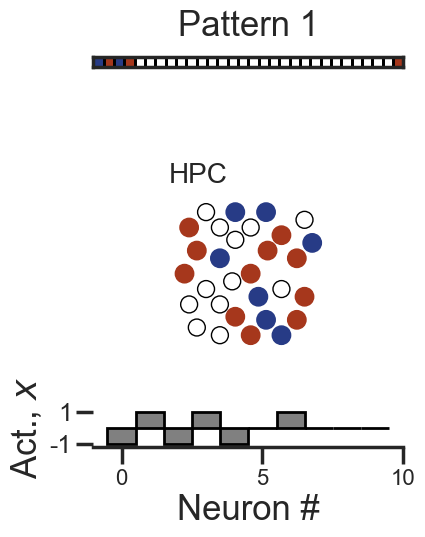

In [34]:
"""
Initialize variables
"""
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[:n_HPC,:n_HPC] = weights_awake_B1B2[:n_HPC,:n_HPC] # set weights of HPC to trained weights.
weights[n_HPC:,n_HPC:] = weights_awake_B1B2[n_HPC:,n_HPC:] # set weights of PFC to trained weights. 

# Firing rates
r =  np.zeros(n_total)

#External input
I = np.array([-1, 1, -1, 1, 0, 0, 0, 0, 0, 0, 0,0 , 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 1]) # incomplete pattern B1
#I = np.array([0, 0, -1, 1, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0,0, 1, 0, 0, 0, 0, 0, 0]) # incomplete pattern B2
Inc_pattern = np.copy(I)
I=np.concatenate((I,I)) # total external input acting on the full network


"""
Run simulation
"""
i=0

while True:  
        
    r_new = r + dt*hopfield(r, weights, I, n_HPC)

    if i>7600:      
        break
        
    i+=1
    r = r_new

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)

"""
Plots
"""
# Figure S11 a2)
fig = plt.figure(figsize=(4, 6))
grid = plt.GridSpec(3, 1, hspace=0.5, height_ratios=[2, 2, 0.5])       
ax_input = fig.add_subplot(grid[0, 0])
plot_input(Inc_pattern, 'Pattern 1', cmap, ax=ax_input)               
ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)
# Bar graph with states for PFC
ax_bar_hpc = fig.add_subplot(grid[2, 0])
print(np.shape(x))
bar_activity(x[:10],r_final_HPC[0,:10], ax=ax_bar_hpc)
plt.savefig('Recall_B2.png', dpi=600, transparent=True,  bbox_inches='tight')
plt.show 

